<a href="https://colab.research.google.com/github/blackbudge98-cpu/gt-markets/blob/main/BTC_Keywords.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
from datetime import date
import pandas as pd
import yfinance as yf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
from google.colab import auth
from googleapiclient.discovery import build
from googleapiclient.http import MediaFileUpload
import os
!pip -q install pytrends
import time, datetime as dt, re
from pytrends.request import TrendReq, exceptions
from dateutil.relativedelta import relativedelta


#The first data set we will want to see is USD over a 10 year period

tickers = ["DXY", "USDCNY=X","BTC-USD","CL=F", "GC=F"]

#The definition of tickers will assist in a batch query rather than a singular batch query

data = yf.download(tickers, period="10y", interval="1d")

# Extract Open, High, Low, and Close data
df_open = data["Open"]
df_high = data["High"]
df_low = data["Low"]
df_close = data["Close"]

# Rename columns to indicate price type
df_open.columns = [f"{col} Open" for col in df_open.columns]
df_high.columns = [f"{col} High" for col in df_high.columns]
df_low.columns = [f"{col} Low" for col in df_low.columns]
df_close.columns = [f"{col} Close" for col in df_close.columns]

# Merge the dataframes
df_merged = pd.merge(df_close, df_open, left_index=True, right_index=True)
df_merged = pd.merge(df_merged, df_high, left_index=True, right_index=True)
df_merged = pd.merge(df_merged, df_low, left_index=True, right_index=True)

# Keep only weekdays
df_merged = df_merged[df_merged.index.dayofweek < 5]

# Fill NaN values with the previous day's data
df_merged = df_merged.fillna(method='ffill')

# Drop the first row
df_merged = df_merged.iloc[1:]

# Calculate the conditional rolling average for each ticker's close price
for ticker in tickers:
    close_col = f"{ticker} Close"
    sma_col = f"{ticker} 20-day simple moving average"
    df_merged[sma_col] = None # Initialize the column with None

    for i in range(len(df_merged)):
        if i < 20:
            window = i + 1
        else:
            window = 20
        df_merged.loc[df_merged.index[i], sma_col] = df_merged[close_col].iloc[max(0, i - window + 1):i + 1].mean()

# Calculate 14-day Relative Strength Index (RSI) for each ticker
for ticker in tickers:
    close_col = f"{ticker} Close"
    rsi_col = f"{ticker} 14-day RSI"

    # Calculate daily price change
    df_merged[f"{ticker} Change"] = df_merged[close_col].diff()

    # Calculate gains and losses
    df_merged[f"{ticker} Gain"] = df_merged[f"{ticker} Change"].apply(lambda x: x if x > 0 else 0)
    df_merged[f"{ticker} Loss"] = df_merged[f"{ticker} Change"].apply(lambda x: abs(x) if x < 0 else 0)

    # Calculate average gain and average loss over 14 days
    # Adjust window size for the first 13 days
    df_merged[f"{ticker} Avg Gain"] = [df_merged[f"{ticker} Gain"].iloc[max(0, i - min(i, 13)):i+1].mean() if i > 0 else np.nan for i in range(len(df_merged))]
    df_merged[f"{ticker} Avg Loss"] = [df_merged[f"{ticker} Loss"].iloc[max(0, i - min(i, 13)):i+1].mean() if i > 0 else np.nan for i in range(len(df_merged))]


    # Calculate Relative Strength (RS)
    df_merged[f"{ticker} RS"] = df_merged[f"{ticker} Avg Gain"] / df_merged[f"{ticker} Avg Loss"]

    # Calculate Relative Strength Index (RSI)
    df_merged[rsi_col] = 100 - (100 / (1 + df_merged[f"{ticker} RS"]))

    # Drop intermediate columns
    df_merged = df_merged.drop(columns=[f"{ticker} Change", f"{ticker} Gain", f"{ticker} Loss", f"{ticker} Avg Gain", f"{ticker} Avg Loss", f"{ticker} RS"])


# Calculate log returns for each ticker
for ticker in tickers:
    close_col = f"{ticker} Close"
    log_return_col = f"{ticker} Log Returns"
    df_merged[log_return_col] = np.log(df_merged[close_col] / df_merged[close_col].shift(1))


# Calculate 30-day rolling volatility for each ticker
for ticker in tickers:
    close_col = f"{ticker} Close"
    volatility_col = f"{ticker} 30-day Rolling Volatility"

    # Calculate daily returns
    df_merged[f"{ticker} Returns"] = df_merged[close_col].pct_change()

    # Calculate rolling volatility using the formula with conditional window
    df_merged[volatility_col] = [df_merged[f"{ticker} Returns"].iloc[max(0, i - min(i, 29)):i + 1].std() if i > 0 else np.nan for i in range(len(df_merged))]

    # Drop intermediate columns
    df_merged = df_merged.drop(columns=[f"{ticker} Returns"])


display(df_merged.head(40))

print("\nAssumptions for Data Calculations:")
print("- 20-day Simple Moving Average: For the first 20 rows, the rolling average window starts from 1 and increases up to the current row number. After the first 20 rows, a fixed 20-day window is used.")
print("- 30-day Rolling Volatility: For the first 29 rows, the rolling volatility window starts from 1 and increases up to the current row number. After the first 29 rows, a fixed 30-day window is used.")

# Authenticate and mount Google Drive
# Check if Google Drive is already mounted
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive', force_remount=True)
else:
    print("Google Drive is already mounted.")

auth.authenticate_user()
drive_service = build('drive', 'v3')

# Define the folder ID and filename for df_merged
merged_folder_id_raw = '1tqNeIkQM2IawFLS-NHBzaDl8fsJAo0t_'  # User specified folder ID for df_merged
today = date.today()
merged_filename_raw = f"financial_data_raw_data_from_yf{today.strftime('%Y-%m-%d')}.csv"
merged_filepath_local_raw = f"/content/{merged_filename_raw}" # Save locally first

# Check if the file already exists in the specified Google Drive folder
file_list_raw = drive_service.files().list(
    q=f"name='{merged_filename_raw}' and '{merged_folder_id_raw}' in parents",
    spaces='drive',
    fields='files(id, name)'
).execute().get('files', [])

if file_list_raw:
    print(f"[skip] File already exists in Google Drive: {merged_filename_raw}")
else:
    # Save the DataFrame to a temporary local CSV file
    # Make sure the dataframe 'df_merged' exists
    try:
        df_merged.to_csv(merged_filepath_local_raw)
    except NameError:
        print("Error: DataFrame 'df_merged' not found. Please run the cell that creates 'df_merged' first.")
        # Exit or handle the error appropriately if df_merged is not defined
        exit()

    # Create a file in the shared drive
    file_metadata_raw = {
        'name': merged_filename_raw,
        'parents': [merged_folder_id_raw]
    }

    media_raw = MediaFileUpload(merged_filepath_local_raw, mimetype='text/csv')

    try:
        gfile_raw = drive_service.files().create(
            body=file_metadata_raw,
            media_body=media_raw,
            fields='id'
        ).execute()

        print(f"File ID: {gfile_raw.get('id')}")
        print(f"Data exported to shared drive folder: {merged_folder_id_raw}")

    except Exception as e:
        print(f"Error exporting data to shared drive: {e}")
        # Handle specific Drive API errors if needed

    # Clean up the local file
    os.remove(merged_filepath_local_raw)


# === Multi-keyword Google Trends Pipeline ===
# What this does:
# - Loops over a list of keywords (like "USD", "gold price", "bitcoin")
# - For each keyword:
#     * If we already have a CSV saved for that keyword, load it (skip download)
#     * If not, download daily Google Trends data in 6-month chunks
#     * Clean it to daily frequency (fill missing values)
#     * Save it to /processed folder
# - Combine all keyword trend files into one dataframe
# - Merge that dataframe into the financial dataset (anchor table)
# - Save everything back into /processed
#
# End result:
#   - One CSV per keyword (trends_<keyword>.csv)
#   - A combined all-keywords trends CSV (trends_all_keywords_daily.csv)
#   - A merged financial+trends CSV (merged_with_trends_multi.csv)

# -----------------------------
# Project folders (we keep everything under /gt-markets/data/google keyword trends)
# -----------------------------
PROJECT_DIR = "/content/drive/MyDrive/gt-markets"
DATA_DIR    = f"{PROJECT_DIR}/data"
PROC_DIR    = f"{DATA_DIR}/google keyword trends" # Renamed processing directory
os.makedirs(PROC_DIR, exist_ok=True)  # make sure /google keyword trends exists

# -----------------------------
# Anchor dataframe (financial data table we merge trends into)
# We prefer "prices" (daily multi-asset data). If not defined, fall back to df_weekday_usd_reordered.
# -----------------------------
try:
    anchor = df_merged.copy()
    print("[info] Using 'df_merged' as the anchor table")
except NameError:
    print("[error] DataFrame 'df_merged' not found. Please run the cell that creates 'df_merged' first.")
    # Exit or handle the error appropriately if df_merged is not defined
    exit()


# Make sure the index (row labels) is datetime so we can align by date
anchor.index = pd.to_datetime(anchor.index)

# Date range for trends = same as the anchor dataframe
start_date = pd.to_datetime(anchor.index.min()).date()
end_date   = pd.to_datetime(anchor.index.max()).date()
print(f"[info] Trends date range: {start_date} → {end_date}")

# -----------------------------
# Keywords we want to track in Google Trends
# Add/remove keywords in this list as needed
# -----------------------------
KEYWORDS = [
    "USD",
    "gold price",
    "bitcoin",
    "oil price",
    "Chinese yuan",
    "inflation",
    "interest rates",
    "stock market",
    "recession",
    "economic growth",
    "currency exchange",
    "commodity prices",
    "treasury bonds",
    "central bank",
    "consumer spending",
    "intervention",
    "gamble",
    "gold",
    "luxury",
    "ruin",
    "associate",
    "cooperative",
    "pollution",
    "success",
    "gift",
    "affluent",
    "benevolence",
    "partnership",
    "poor",
    "blackmail",
    "privileged",
    "ghetto",
    "extravagant",
    "nobility",
    "cheap",
    "entrepreneurial,",
    "jobless",
    "shortage",
    "fellowship",
    "inexpensive",
    "valuable",
    "bargain",
    "colony",
    "liquidation",
    "debt",
    "color",
    "restaurant",
    "portfolio",
    "housing",
    "dow jones",
    "revenue",
    "credit",
    "unemployment",
    "money",
    "religion",
    "cancer",
    "growth",
    "investment",
    "hedge",
    "marriage",
    "bonds",
    "cash",
    "office",
    "car",
    "nasdaq",
    "gains",
    "finance",
    "sell",
    "metals",
    "travel",
    "chance",
    "cryptocurrency",
    "satoshi",
    "El Salvador",
    "Solana",
    "Tesla",
    "Bitcoin Mining",
    "Blockchain",
    "Silk Road",
    "Tor",
    "Nigeria",
    "Legal Tender",
    "Nayib Bukele"

]

# -----------------------------
# Helper: convert a keyword into a safe slug (for filenames and column names)
# Example: "Gold Price" -> "gold_price"
# -----------------------------
def slugify(text: str) -> str:
    text = text.strip().lower()
    text = re.sub(r"[^a-z0-9]+", "_", text)  # replace spaces/symbols with "_"
    return text.strip("_")

# -----------------------------
# Helper: yield 6-month chunks between start_date and end_date
# Google Trends only lets you pull limited time spans at once
# -----------------------------
def daterange_chunks(s: dt.date, e: dt.date, months=6):
    cur = s
    while cur <= e:
        nxt = min(cur + relativedelta(months=months) - relativedelta(days=1), e)
        yield cur, nxt
        cur = nxt + relativedelta(days=1)

# -----------------------------
# Helper: fetch daily Google Trends for one keyword
# Steps:
#   - Loop over chunks (6 months each)
#   - Request data from Google
#   - Collect into a dataframe
#   - Align to daily frequency (forward fill missing days)
# -----------------------------
def fetch_trends_daily(keyword: str, start_date: dt.date, end_date: dt.date, months_per_chunk: int = 6) -> pd.DataFrame:
    pt = TrendReq(hl="en-US", tz=0)  # session for Google Trends
    frames = []
    for i, (s, e) in enumerate(daterange_chunks(start_date, end_date, months_per_chunk), 1):
        timeframe = f"{s} {e}"
        tries, delay = 0, 8
        too_many_requests_count = 0 # Counter for 429 errors for this chunk
        while True:
            try:
                pt.build_payload([keyword], timeframe=timeframe, geo='', gprop='')
                part = pt.interest_over_time().drop(columns=["isPartial"], errors="ignore")
                if len(part):
                    part = part.rename(columns={keyword: keyword})
                    frames.append(part)
                print(f"[ok] {keyword} chunk {i}: {s} → {e}, rows={len(part)}")
                time.sleep(1.0)  # polite pause so Google doesn't block us
                break
            except exceptions.TooManyRequestsError as ex: # Catch the specific error
                too_many_requests_count += 1
                if too_many_requests_count >= 3: # Check if 3 or more 429 errors occurred for this chunk
                    print(f"\n[429/Too Many Requests] 3 errors for {keyword} {timeframe}. Skipping this keyword.")
                    return pd.DataFrame() # Return empty dataframe to signal skipping to next keyword
                print(f"\n[429/Too Many Requests] Error for {keyword} {timeframe}. Waiting 10 minutes. (Error count: {too_many_requests_count}/3)")
                time.sleep(600) # Wait for 10 minutes
                # Continue the inner while loop to retry this chunk
            except Exception as ex:
                tries += 1
                if tries > 5:  # give up after 5 retries
                    print(f"[warn] {keyword} failed for {timeframe}: {ex}")
                    break
                print(f"[backoff] {keyword} {timeframe} → sleep {delay}s … (try {tries}/5)")
                time.sleep(delay)
                delay = min(int(delay * 1.8), 180)  # exponential backoff

    if not frames:
        return pd.DataFrame()  # nothing returned

    # Combine all chunks into one dataframe
    out = pd.concat(frames).sort_index()
    out.index = pd.to_datetime(out.index)
    # Force daily frequency (if Google gave weekly, fill in the missing days)
    out = out.asfreq("D").ffill()
    return out

# -----------------------------
# Main loop over keywords
# For each keyword:
#   - If CSV already exists, load it
#   - Else fetch from Google and save
#   - Ensure column has a unique name (<keyword>_trend)
#   - Add to all_trends list for later combination
# -----------------------------
all_trends = []

# Authenticate and mount Google Drive (if not already mounted)
try:
    drive.mount('/content/drive', force_remount=True)
    auth.authenticate_user()
    drive_service = build('drive', 'v3')
except Exception as e:
    print(f"Google Drive authentication or mount failed: {e}")
    # Exit or handle the error appropriately if mount fails
    pass

# Define the Google Drive folder ID for keyword CSVs
keyword_folder_id = '1nYgH5q4WSvaNxFMIMHb72m3SWLzuwjDH' # User specified folder ID for keyword CSVs

for kw in KEYWORDS:
    print(f"\n=== Keyword: {kw} ===")
    slug = slugify(kw)
    col_name = f"{slug}_trend"
    per_kw_filename = f"trends_{slug}_daily.csv"
    per_kw_filepath_local = f"/content/{per_kw_filename}" # Save locally first

    # Check if file exists in the specified Google Drive folder
    file_list = drive_service.files().list(
        q=f"name='{per_kw_filename}' and '{keyword_folder_id}' in parents",
        spaces='drive',
        fields='files(id, name)'
    ).execute().get('files', [])

    if file_list:
        # If file already exists, load it from Google Drive
        print(f"[skip] Found existing file in Google Drive: {per_kw_filename}")
        file_id = file_list[0]['id']
        # Download the file
        request = drive_service.files().get_media(fileId=file_id)
        with open(per_kw_filepath_local, 'wb') as f:
            from googleapiclient.http import MediaIoBaseDownload
            downloader = MediaIoBaseDownload(f, request)
            done = False
            while done is False:
                status, done = downloader.next_chunk()
                print(f"Download {int(status.progress() * 100)}%.")

        tdf = pd.read_csv(per_kw_filepath_local, index_col=0, parse_dates=True)
        # Ensure daily grid (if old file had weekly rows)
        tdf = tdf.asfreq("D").ffill()
        os.remove(per_kw_filepath_local) # Clean up local file after loading

    else:
        # Download from Google Trends
        tdf = fetch_trends_daily(kw, start_date, end_date)
        if tdf.empty:
            print(f"[warn] No data for '{kw}'. Skipping.")
            continue
        # Rename column to e.g. "usd_trend" or "gold_price_trend"
        tdf = tdf.rename(columns={kw: col_name})
        # Save to a temporary local CSV file
        tdf.to_csv(per_kw_filepath_local)

        # Upload to the specified Google Drive folder
        file_metadata = {
            'name': per_kw_filename,
            'parents': [keyword_folder_id]
        }
        media = MediaFileUpload(per_kw_filepath_local, mimetype='text/csv')
        try:
            gfile = drive_service.files().create(
                body=file_metadata,
                media_body=media,
                fields='id'
            ).execute()
            print(f"[ok] saved {kw}: {tdf.shape} → Google Drive File ID: {gfile.get('id')}")
        except Exception as e:
            print(f"Error uploading {per_kw_filename} to Google Drive: {e}")

        os.remove(per_kw_filepath_local) # Clean up local file after uploading


    # Safety check: make sure column name is correct
    if col_name not in tdf.columns:
        tdf = tdf.rename(columns={tdf.columns[0]: col_name})

    # Keep only the single trend column
    all_trends.append(tdf[[col_name]])

# -----------------------------
# Combine all keyword trend dataframes into one
# Save the combined trends CSV to the specified Google Drive folder
# -----------------------------
if all_trends:
    trends_all = pd.concat(all_trends, axis=1).sort_index()
    trends_all_filename = "trends_all_keywords_daily.csv"
    trends_all_filepath_local = f"/content/{trends_all_filename}" # Save locally first
    trends_all.to_csv(trends_all_filepath_local)

    # Upload the combined trends CSV to the specified Google Drive folder
    file_metadata = {
        'name': trends_all_filename,
        'parents': [keyword_folder_id] # Save in the same keyword folder
    }
    media = MediaFileUpload(trends_all_filepath_local, mimetype='text/csv')
    try:
        gfile = drive_service.files().create(
            body=file_metadata,
            media_body=media,
            fields='id'
        ).execute()
        print(f"[ok] saved combined trends: {trends_all.shape} → Google Drive File ID: {gfile.get('id')}")
    except Exception as e:
        print(f"Error uploading {trends_all_filename} to Google Drive: {e}")

    os.remove(trends_all_filepath_local) # Clean up local file

    # Merge trends into anchor financial dataset (keep all rows from anchor)
    merged = anchor.join(trends_all, how="left")
else:
    print("[warn] No trends tables created; merged will just equal anchor table")
    merged = anchor.copy()

# -----------------------------
# Save the merged financial+trends dataset to Google Drive (original folder)
# -----------------------------
# Authenticate and mount Google Drive (if not already mounted)
# This part is already done at the beginning, but keeping it here for clarity if this section were standalone
# try:
#     drive.mount('/content/drive', force_remount=True)
#     auth.authenticate_user()
#     drive_service = build('drive', 'v3')
# except Exception as e:
#     print(f"Google Drive authentication or mount failed: {e}")
#     # Exit or handle the error appropriately if mount fails
#     pass

# Define the folder ID for the merged data (original folder)
merged_folder_id = '1wOqTixtRA5n5uHN1ptfIbQm6suTrLDxA'  # Original User specified folder ID
today = date.today()
merged_filename = f"merged_financial_trends_data_{today.strftime('%Y-%m-%d')}.csv"
merged_filepath_local = f"/content/{merged_filename}" # Save locally first

# Check if the merged file already exists in the specified Google Drive folder
file_list_merged = drive_service.files().list(
    q=f"name='{merged_filename}' and '{merged_folder_id}' in parents",
    spaces='drive',
    fields='files(id, name)'
).execute().get('files', [])

if file_list_merged:
    print(f"[skip] Merged file already exists in Google Drive: {merged_filename}")
else:
    # Save the merged DataFrame to a temporary local CSV file
    merged.to_csv(merged_filepath_local)

    # Create a file in the shared drive using the Google Drive API
    file_metadata_merged = {
        'name': merged_filename,
        'parents': [merged_folder_id]
    }

    media_merged = MediaFileUpload(merged_filepath_local, mimetype='text/csv')

    try:
        gfile_merged = drive_service.files().create(
            body=file_metadata_merged,
            media_body=media_merged,
            fields='id'
        ).execute()

        print(f"Merged Data File ID: {gfile_merged.get('id')}")
        print(f"Merged Data exported to shared drive folder: {merged_folder_id}")

    except Exception as e:
        print(f"Error exporting data to shared drive: {e}")

    # Clean up the local file
    os.remove(merged_filepath_local)


# -----------------------------
# Tips for adding keywords later:
# - Just add the new keyword text to the KEYWORDS list above
# - Run the cell again
# - The code will automatically fetch and save only the new ones
# - Existing CSVs will be reused (skipped)
# -----------------------------

/tmp/ipython-input-4284510646.py:24: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period="10y", interval="1d")
[*********************100%***********************]  5 of 5 completed
/tmp/ipython-input-4284510646.py:47: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_merged = df_merged.fillna(method='ffill')
/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,BTC-USD Close,CL=F Close,DXY Close,GC=F Close,USDCNY=X Close,BTC-USD Open,CL=F Open,DXY Open,GC=F Open,USDCNY=X Open,...,DXY Log Returns,USDCNY=X Log Returns,BTC-USD Log Returns,CL=F Log Returns,GC=F Log Returns,DXY 30-day Rolling Volatility,USDCNY=X 30-day Rolling Volatility,BTC-USD 30-day Rolling Volatility,CL=F 30-day Rolling Volatility,GC=F 30-day Rolling Volatility
Date,,,,,,,,,,,,,,,,,,,,,
2015-09-08,243.606995,45.939999,930.440002,1120.400024,6.3559,239.845993,45.820000,930.440002,1119.800049,6.3559,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-09-09,238.167999,44.150002,938.400024,1102.199951,6.3572,243.414993,45.790001,938.400024,1123.500000,6.3572,...,0.008519,0.000205,-0.022580,-0.039743,-0.016378,NaN,NaN,NaN,NaN,NaN
2015-09-10,238.477005,45.919998,913.510010,1109.500000,6.3678,238.335999,44.160000,913.510010,1107.300049,6.3678,...,-0.026882,0.001666,0.001297,0.039308,0.006601,0.024805,0.001034,0.016705,0.055900,0.016170
2015-09-11,240.106995,44.630001,922.140015,1103.500000,6.3672,238.328995,45.709999,922.140015,1110.800049,6.3672,...,0.009403,-0.000094,0.006812,-0.028494,-0.005423,0.020515,0.000943,0.015488,0.042850,0.011439
2015-09-14,230.643997,44.000000,941.059998,1107.699951,6.3650,230.608994,44.779999,941.059998,1107.800049,6.3650,...,0.020310,-0.000346,-0.040209,-0.014217,0.003799,0.020420,0.000901,0.021461,0.035081,0.010328
2015-09-15,230.304001,44.590000,991.849976,1102.800049,6.3579,230.492004,44.110001,991.849976,1104.500000,6.3579,...,0.052565,-0.001116,-0.001475,0.013320,-0.004433,0.028851,0.001022,0.019336,0.032173,0.008973
2015-09-16,229.091003,47.150002,982.549988,1119.199951,6.3600,230.250000,45.160000,982.549988,1109.800049,6.3600,...,-0.009421,0.000330,-0.005281,0.055824,0.014762,0.027401,0.000920,0.017453,0.038581,0.010882
2015-09-17,229.809998,46.900002,991.849976,1117.300049,6.3609,229.076004,47.130001,991.849976,1118.599976,6.3609,...,0.009421,0.000141,0.003134,-0.005316,-0.001699,0.025013,0.000840,0.016695,0.035432,0.009952
2015-09-18,232.975006,44.680000,1039.979980,1138.099976,6.3560,233.520996,46.889999,1039.979980,1128.300049,6.3560,...,0.047385,-0.000771,0.013678,-0.048492,0.018445,0.026968,0.000838,0.017295,0.037403,0.011396



Assumptions for Data Calculations:
- 20-day Simple Moving Average: For the first 20 rows, the rolling average window starts from 1 and increases up to the current row number. After the first 20 rows, a fixed 20-day window is used.
- 30-day Rolling Volatility: For the first 29 rows, the rolling volatility window starts from 1 and increases up to the current row number. After the first 29 rows, a fixed 30-day window is used.
Google Drive is already mounted.
[skip] File already exists in Google Drive: financial_data_raw_data_from_yf2025-09-07.csv
[info] Using 'df_merged' as the anchor table
[info] Trends date range: 2015-09-08 → 2025-09-05
Mounted at /content/drive

=== Keyword: USD ===
[skip] Found existing file in Google Drive: trends_usd_daily.csv
Download 100%.

=== Keyword: gold price ===
[skip] Found existing file in Google Drive: trends_gold_price_daily.csv
Download 100%.

=== Keyword: bitcoin ===
[skip] Found existing file in Google Drive: trends_bitcoin_daily.csv
Download 100%.


Starting analysis with the merged dataframe.

Created BTC-USD specific dataframe including all trends.


,BTC-USD Close,BTC-USD Open,BTC-USD High,BTC-USD Low,BTC-USD 20-day simple moving average,BTC-USD 14-day RSI,BTC-USD Log Returns,BTC-USD 30-day Rolling Volatility,usd_trend,gold_price_trend,...,el_salvador_trend,solana_trend,tesla_trend,bitcoin_mining_trend,blockchain_trend,silk_road_trend,tor_trend,nigeria_trend,legal_tender_trend,nayib_bukele_trend
Date,,,,,,,,,,,,,,,,,,,,,
2015-09-08,243.606995,239.845993,245.781006,239.677994,243.606995,NaN,NaN,NaN,93,52,...,54,80,29,35,39,54,72,58,44,0
2015-09-09,238.167999,243.414993,244.416000,237.820999,240.887497,0.000000,-0.022580,NaN,92,50,...,52,73,28,36,44,56,73,58,52,0
2015-09-10,238.477005,238.335999,241.292999,235.791000,240.084,5.375882,0.001297,0.016705,91,59,...,45,69,31,38,47,60,74,54,59,27
2015-09-11,240.106995,238.328995,241.169006,238.328995,240.089748,26.280805,0.006812,0.015488,83,52,...,41,74,32,33,39,57,72,58,47,0
2015-09-14,230.643997,230.608994,232.440002,227.960999,238.200598,11.513549,-0.040209,0.021461,85,51,...,41,80,29,36,42,66,94,56,57,0



Shape of the BTC-USD dataframe after dropping rows with NaN for correlation:
(1436, 91)

Correlation of 'BTC-USD Log Returns' with Keyword Trends:


,BTC-USD Log Returns
unemployment_trend,0.060370
nobility_trend,0.056243
bargain_trend,0.055781
marriage_trend,0.054483
entrepreneurial_trend,0.049122
...,...
extravagant_trend,-0.056632
silk_road_trend,-0.059401
chinese_yuan_trend,-0.067218
colony_trend,-0.069321


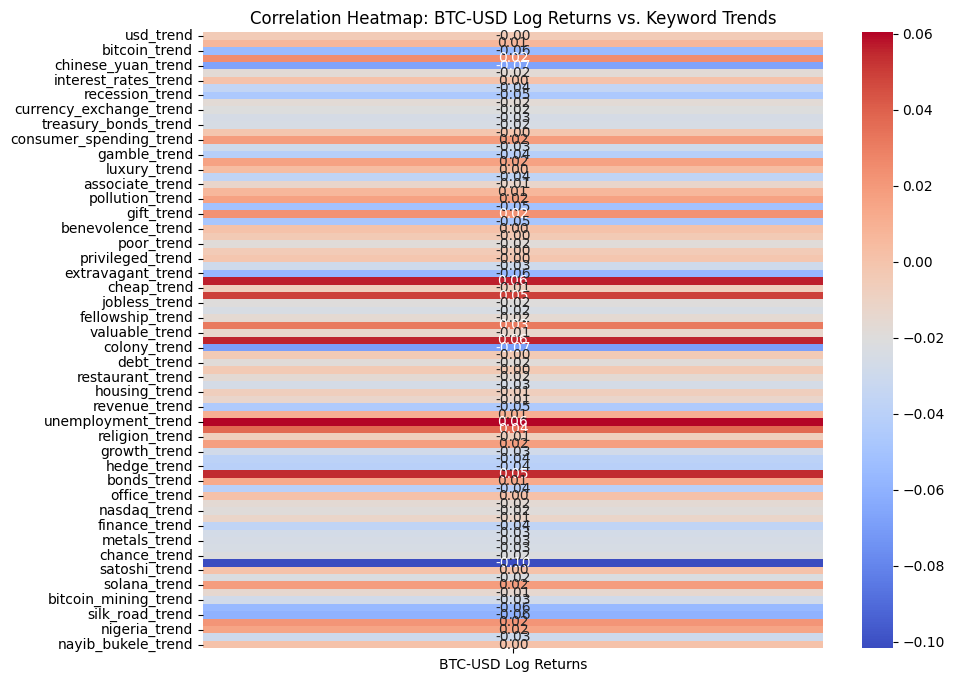


--- Linear Regression (Example with 'bitcoin_trend') ---
                             OLS Regression Results                            
Dep. Variable:     BTC-USD Log Returns   R-squared:                       0.003
Model:                             OLS   Adj. R-squared:                  0.002
Method:                  Least Squares   F-statistic:                     4.385
Date:                 Sun, 07 Sep 2025   Prob (F-statistic):             0.0364
Time:                         02:48:08   Log-Likelihood:                 2352.5
No. Observations:                 1436   AIC:                            -4701.
Df Residuals:                     1434   BIC:                            -4690.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

,Lag 1,Lag 2,Lag 3,Lag 4,Lag 5
usd,-0.032819,-0.022655,-0.020986,-0.031926,-0.031579
gold_price,-0.000386,-0.002315,-0.008958,-0.034878,-0.035710
bitcoin,-0.071045,-0.063679,-0.073271,-0.076143,-0.053516
oil_price,0.028760,0.033440,0.012424,0.025388,0.025420
chinese_yuan,-0.067570,-0.074259,-0.079764,-0.084001,-0.083098
...,...,...,...,...,...
silk_road,-0.070709,-0.058234,-0.057692,-0.055694,-0.063118
tor,0.023497,0.029227,0.036824,0.041632,0.043800
nigeria,0.034093,0.034597,0.034680,0.037785,0.027520
legal_tender,-0.045566,-0.032895,-0.023865,-0.062327,-0.047409



--- Keywords with Significant Lagged Correlation (|r| > 0.05) for BTC-USD ---


,Pair,Keyword,Correlation,trading lag
0,BTC-USD,bitcoin,-0.071,1 day
1,BTC-USD,bitcoin,-0.064,2 day
2,BTC-USD,bitcoin,-0.073,3 day
3,BTC-USD,bitcoin,-0.076,4 day
4,BTC-USD,bitcoin,-0.054,5 day
...,...,...,...,...
57,BTC-USD,silk_road,-0.058,2 day
58,BTC-USD,silk_road,-0.058,3 day
59,BTC-USD,silk_road,-0.056,4 day
60,BTC-USD,silk_road,-0.063,5 day


[skip] Significant correlations file already exists in Google Drive: btc_usd_significant_lagged_correlations.csv


In [59]:
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from googleapiclient.discovery import build
from googleapiclient.http import MediaFileUpload

# Define the Google Drive folder ID for the filtered data
filtered_folder_id = '1lQQLKf8FRlt0wmu91-MyOYER40o3Oej1' # User specified folder ID

# Ensure 'merged' dataframe is available and not empty
if 'merged' in locals() and not merged.empty:
    print("Starting analysis with the merged dataframe.")

    # --- Prepare BTC-USD specific dataframe including all trends ---
    btc_specific_columns = [col for col in merged.columns if 'BTC-USD' in col]
    trend_columns = [col for col in merged.columns if col.endswith('_trend')]
    df_btc = merged[btc_specific_columns + trend_columns].copy()
    print("\nCreated BTC-USD specific dataframe including all trends.")
    display(df_btc.head())

    # --- Calculate and display the correlation of 'BTC-USD Log Returns' with Keyword Trends ---
    # Drop rows with NaN values from df_btc for correlation calculation
    df_btc_cleaned = df_btc.dropna().copy()

    print("\nShape of the BTC-USD dataframe after dropping rows with NaN for correlation:")
    print(df_btc_cleaned.shape)

    btc_log_returns_column = 'BTC-USD Log Returns'

    if btc_log_returns_column in df_btc_cleaned.columns:
        btc_log_returns_correlation = df_btc_cleaned.corr()[btc_log_returns_column]

        # Filter to show only correlations with trend columns
        trend_correlations = btc_log_returns_correlation[btc_log_returns_correlation.index.str.endswith('_trend')]


        print("\nCorrelation of 'BTC-USD Log Returns' with Keyword Trends:")
        display(trend_correlations.sort_values(ascending=False))

        # Create a heatmap of the correlations between BTC-USD Log Returns and trend columns
        if not trend_correlations.empty:
            plt.figure(figsize=(10, 8)) # Adjust figure size for better readability
            sns.heatmap(trend_correlations.to_frame(), annot=True, cmap='coolwarm', fmt=".2f")
            plt.title('Correlation Heatmap: BTC-USD Log Returns vs. Keyword Trends')
            plt.show()
        else:
            print("\nNo trend correlations to display heatmap for (trend_correlations is empty).")

    else:
        print("\n'BTC-USD Log Returns' column not found in the cleaned BTC-USD DataFrame.")


else:
    print("\nCombined dataframe is empty or not found, cannot perform correlation analysis.")
    df_btc = pd.DataFrame()

# --- Linear Regression ---
print("\n--- Linear Regression (Example with 'bitcoin_trend') ---")

# Drop rows with NaN values for the specific columns needed for regression
# (df_btc_cleaned was already created and NaNs dropped in the previous cell)
# We'll use df_btc_cleaned directly

# Define dependent and independent variables
# Using 'bitcoin_trend' as an example predictor
if 'BTC-USD Log Returns' in df_btc_cleaned.columns and 'bitcoin_trend' in df_btc_cleaned.columns:
    y = df_btc_cleaned['BTC-USD Log Returns']
    X = df_btc_cleaned['bitcoin_trend']

    # Add a constant to the independent variable for the intercept
    X = sm.add_constant(X)

    # Fit the linear regression model
    model = sm.OLS(y, X).fit()

    # Print the regression summary
    print(model.summary())
else:
    print("Required columns for linear regression not found in df_btc_cleaned.")

print("\n--- Lagged Correlations ---")

# Calculate lagged correlations for all keyword trends
lag_periods = 5 # Check correlations for lags up to 5 days

# Get all keyword trend columns
all_trend_keywords = [col for col in df_btc_cleaned.columns if col.endswith('_trend')]

keywords_with_significant_lagged_correlation = []
lagged_correlations_list = [] # List to store lagged correlations for each keyword

for keyword in all_trend_keywords:
    if 'BTC-USD Log Returns' in df_btc_cleaned.columns:
        lagged_correlations = {}
        has_significant_lag = False
        for lag in range(1, lag_periods + 1):
            # Shift the trend data by the lag period (lagged trend data)
            lagged_trend = df_btc_cleaned[keyword].shift(lag)

            # Calculate correlation between BTC-USD Log Returns and lagged trend
            correlation = df_btc_cleaned['BTC-USD Log Returns'].corr(lagged_trend)
            lagged_correlations[f"Lag {lag}"] = correlation

            # Check for significant correlation (using 0.05 threshold)
            if pd.notna(correlation) and abs(correlation) > 0.05:
                has_significant_lag = True

        # Append the lagged correlations for the current keyword to the list
        lagged_correlations_list.append(pd.Series(lagged_correlations, name=keyword.replace('_trend', '')))


        if has_significant_lag:
            keywords_with_significant_lagged_correlation.append(keyword)

    else:
        print(f"\nRequired columns for lagged correlation with '{keyword}' not found in df_btc_cleaned.")

# Combine all lagged correlations into a single DataFrame
if lagged_correlations_list:
    all_lagged_correlations_df = pd.concat(lagged_correlations_list, axis=1).T
    print("\nLagged Correlations (BTC-USD Log Returns vs. Keyword Trends):")
    display(all_lagged_correlations_df)
else:
    print("\nNo lagged correlations to display.")


print("\n--- Keywords with Significant Lagged Correlation (|r| > 0.05) for BTC-USD ---")
export_data = []
if keywords_with_significant_lagged_correlation:
    for keyword in keywords_with_significant_lagged_correlation:
        keyword_name = keyword.replace('_trend', '')
        for lag in range(1, lag_periods + 1):
            correlation_value = all_lagged_correlations_df.loc[keyword_name, f"Lag {lag}"]
            if pd.notna(correlation_value) and abs(correlation_value) > 0.05:
                 export_data.append({
                     'Pair': 'BTC-USD',
                     'Keyword': keyword_name,
                     'Correlation': f"{correlation_value:.3f}",
                     'trading lag': f"{lag} day"
                 })
    export_df = pd.DataFrame(export_data)
    display(export_df)

else:
    print("No keywords found with absolute lagged correlation greater than 0.05 at any lag period for BTC-USD.")
    export_df = pd.DataFrame(columns=['Pair', 'Keyword', 'Correlation', 'trading lag']) # Create empty DataFrame if no significant correlations

# --- Export export_df to Google Drive ---
btc_sig_corr_filename = "btc_usd_significant_lagged_correlations.csv"
btc_sig_corr_filepath_local = f"/content/{btc_sig_corr_filename}" # Save locally first

# Check if the file already exists in the specified Google Drive folder
try:
    # Authenticate and build the Drive service (assuming it's already mounted)
    try:
        drive_service = build('drive', 'v3')
    except Exception as e:
        print(f"Error building Google Drive service: {e}")
        drive_service = None # Ensure drive_service is None if build fails

    if drive_service:
        file_list_btc_sig_corr = drive_service.files().list(
            q=f"name='{btc_sig_corr_filename}' and '{filtered_folder_id}' in parents",
            spaces='drive',
            fields='files(id, name)'
        ).execute().get('files', [])

        if file_list_btc_sig_corr:
            print(f"[skip] Significant correlations file already exists in Google Drive: {btc_sig_corr_filename}")
        else:
            # Save the DataFrame to a temporary local CSV file
            export_df.to_csv(btc_sig_corr_filepath_local, index=False)

            # Create a file in the shared drive using the Google Drive API
            file_metadata_btc_sig_corr = {
                'name': btc_sig_corr_filename,
                'parents': [filtered_folder_id]
            }

            media_btc_sig_corr = MediaFileUpload(btc_sig_corr_filepath_local, mimetype='text/csv')

            gfile_btc_sig_corr = drive_service.files().create(
                body=file_metadata_btc_sig_corr,
                media_body=media_btc_sig_corr,
                fields='id'
            ).execute()

            print(f"Significant Correlations File ID: {gfile_btc_sig_corr.get('id')}")
            print(f"Significant BTC-USD correlations data exported to shared drive folder: {filtered_folder_id}")

            # Clean up the local file
            os.remove(btc_sig_corr_filepath_local)
    else:
        print("Google Drive service not available. Cannot export significant correlations.")

except Exception as e:
    print(f"Error exporting significant BTC-USD correlations data to shared drive: {e}")
    # Clean up local file if it exists after an error
    if os.path.exists(btc_sig_corr_filepath_local):
        os.remove(btc_sig_corr_filepath_local)

Starting analysis with the merged dataframe.

Created USDCNY=X specific dataframe including all trends.


,USDCNY=X Close,USDCNY=X Open,USDCNY=X High,USDCNY=X Low,USDCNY=X 20-day simple moving average,USDCNY=X 14-day RSI,USDCNY=X Log Returns,USDCNY=X 30-day Rolling Volatility,usd_trend,gold_price_trend,...,el_salvador_trend,solana_trend,tesla_trend,bitcoin_mining_trend,blockchain_trend,silk_road_trend,tor_trend,nigeria_trend,legal_tender_trend,nayib_bukele_trend
Date,,,,,,,,,,,,,,,,,,,,,
2015-09-08,6.3559,6.3559,6.3611,6.3520,6.3559,NaN,NaN,NaN,93,52,...,54,80,29,35,39,54,72,58,44,0
2015-09-09,6.3572,6.3572,6.3680,6.3540,6.35655,100.000000,0.000205,NaN,92,50,...,52,73,28,36,44,56,73,58,52,0
2015-09-10,6.3678,6.3678,6.3764,6.3610,6.3603,100.000000,0.001666,0.001034,91,59,...,45,69,31,38,47,60,74,54,59,27
2015-09-11,6.3672,6.3672,6.3672,6.3567,6.362025,95.197589,-0.000094,0.000943,83,52,...,41,74,32,33,39,57,72,58,47,0
2015-09-14,6.3650,6.3650,6.3650,6.3578,6.36262,80.950373,-0.000346,0.000901,85,51,...,41,80,29,36,42,66,94,56,57,0



Shape of the USDCNY=X dataframe after dropping rows with NaN for correlation:
(1436, 91)

Correlation of 'USDCNY=X Log Returns' with Keyword Trends:


,USDCNY=X Log Returns
silk_road_trend,0.062649
el_salvador_trend,0.062515
intervention_trend,0.055819
office_trend,0.054085
affluent_trend,0.053317
...,...
bargain_trend,-0.043319
bonds_trend,-0.043844
chance_trend,-0.046947
religion_trend,-0.047402


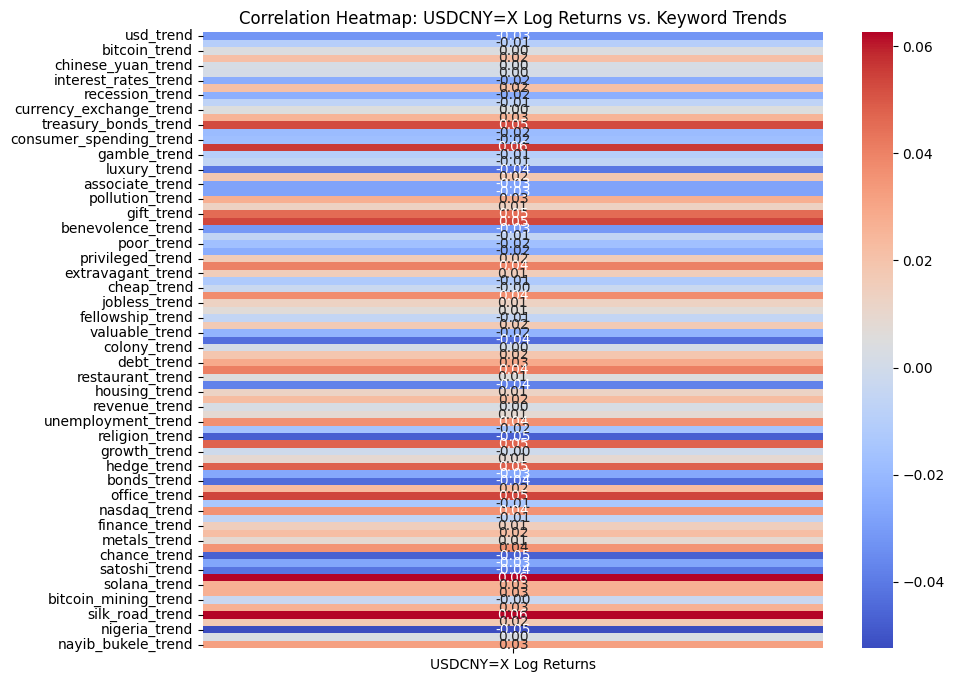


--- Linear Regression (Example with 'chinese_yuan_trend') ---
                             OLS Regression Results                             
Dep. Variable:     USDCNY=X Log Returns   R-squared:                       0.000
Model:                              OLS   Adj. R-squared:                 -0.001
Method:                   Least Squares   F-statistic:                  0.006881
Date:                  Sun, 07 Sep 2025   Prob (F-statistic):              0.934
Time:                          02:48:10   Log-Likelihood:                 6471.9
No. Observations:                  1436   AIC:                        -1.294e+04
Df Residuals:                      1434   BIC:                        -1.293e+04
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

,Lag 1,Lag 2,Lag 3,Lag 4,Lag 5
usd,-0.029782,-0.039850,-0.036765,-0.042426,-0.033757
gold_price,-0.016781,-0.026380,-0.031592,-0.037067,-0.038653
bitcoin,-0.018926,0.003137,0.003110,-0.004766,0.005919
oil_price,0.017656,0.020756,0.026638,0.027589,0.014922
chinese_yuan,-0.002815,-0.034705,-0.018823,-0.008630,-0.007222
...,...,...,...,...,...
silk_road,0.039819,0.053550,0.070632,0.054768,0.071859
tor,0.018854,-0.000173,0.004353,0.015260,0.002812
nigeria,-0.052698,-0.036034,-0.036569,-0.039841,-0.043695
legal_tender,-0.000834,-0.005553,0.011067,0.006122,0.030038



--- Keywords with Significant Lagged Correlation (|r| > 0.05) for USDCNY=X ---


,Pair,Keyword,Correlation,trading lag
0,USDCNY=X,inflation,0.053,4 day
1,USDCNY=X,commodity_prices,0.060,3 day
2,USDCNY=X,commodity_prices,0.056,5 day
3,USDCNY=X,treasury_bonds,0.072,1 day
4,USDCNY=X,treasury_bonds,0.056,2 day
5,USDCNY=X,treasury_bonds,0.082,3 day
6,USDCNY=X,treasury_bonds,0.074,4 day
7,USDCNY=X,treasury_bonds,0.083,5 day
8,USDCNY=X,intervention,0.063,3 day
9,USDCNY=X,intervention,0.068,4 day


[skip] Significant correlations file already exists in Google Drive: usdcny_x_significant_lagged_correlations.csv


In [60]:
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from googleapiclient.discovery import build
from googleapiclient.http import MediaFileUpload

# Define the Google Drive folder ID for the filtered data
filtered_folder_id = '1lQQLKf8FRlt0wmu91-MyOYER40o3Oej1' # User specified folder ID

# Ensure 'merged' dataframe is available and not empty
if 'merged' in locals() and not merged.empty:
    print("Starting analysis with the merged dataframe.")

    # --- Prepare USDCNY=X specific dataframe including all trends ---
    usdcny_specific_columns = [col for col in merged.columns if 'USDCNY=X' in col]
    trend_columns = [col for col in merged.columns if col.endswith('_trend')]
    df_usdcny = merged[usdcny_specific_columns + trend_columns].copy()
    print("\nCreated USDCNY=X specific dataframe including all trends.")
    display(df_usdcny.head())

    # --- Calculate and display the correlation of 'USDCNY=X Log Returns' with Keyword Trends ---
    # Drop rows with NaN values from df_usdcny for correlation calculation
    df_usdcny_cleaned = df_usdcny.dropna().copy()

    print("\nShape of the USDCNY=X dataframe after dropping rows with NaN for correlation:")
    print(df_usdcny_cleaned.shape)

    usdcny_log_returns_column = 'USDCNY=X Log Returns'

    if usdcny_log_returns_column in df_usdcny_cleaned.columns:
        usdcny_log_returns_correlation = df_usdcny_cleaned.corr()[usdcny_log_returns_column]

        # Filter to show only correlations with trend columns
        trend_correlations = usdcny_log_returns_correlation[usdcny_log_returns_correlation.index.str.endswith('_trend')]


        print("\nCorrelation of 'USDCNY=X Log Returns' with Keyword Trends:")
        display(trend_correlations.sort_values(ascending=False))

        # Create a heatmap of the correlations between USDCNY=X Log Returns and trend columns
        if not trend_correlations.empty:
            plt.figure(figsize=(10, 8)) # Adjust figure size for better readability
            sns.heatmap(trend_correlations.to_frame(), annot=True, cmap='coolwarm', fmt=".2f")
            plt.title('Correlation Heatmap: USDCNY=X Log Returns vs. Keyword Trends')
            plt.show()
        else:
            print("\nNo trend correlations to display heatmap for (trend_correlations is empty).")

    else:
        print("\n'USDCNY=X Log Returns' column not found in the cleaned USDCNY=X DataFrame.")


else:
    print("\nCombined dataframe is empty or not found, cannot perform correlation analysis.")
    df_usdcny = pd.DataFrame()

# --- Linear Regression ---
print("\n--- Linear Regression (Example with 'chinese_yuan_trend') ---")

# Drop rows with NaN values for the specific columns needed for regression
# (df_usdcny_cleaned was already created and NaNs dropped in the previous cell)
# We'll use df_usdcny_cleaned directly

# Define dependent and independent variables
# Using 'chinese_yuan_trend' as an example predictor
if 'USDCNY=X Log Returns' in df_usdcny_cleaned.columns and 'chinese_yuan_trend' in df_usdcny_cleaned.columns:
    y = df_usdcny_cleaned['USDCNY=X Log Returns']
    X = df_usdcny_cleaned['chinese_yuan_trend']

    # Add a constant to the independent variable for the intercept
    X = sm.add_constant(X)

    # Fit the linear regression model
    model = sm.OLS(y, X).fit()

    # Print the regression summary
    print(model.summary())
else:
    print("Required columns for linear regression not found in df_usdcny_cleaned.")

print("\n--- Lagged Correlations ---")

# Calculate lagged correlations for all keyword trends
lag_periods = 5 # Check correlations for lags up to 5 days

# Get all keyword trend columns
all_trend_keywords = [col for col in df_usdcny_cleaned.columns if col.endswith('_trend')]

keywords_with_significant_lagged_correlation = []
lagged_correlations_list = [] # List to store lagged correlations for each keyword

for keyword in all_trend_keywords:
    if 'USDCNY=X Log Returns' in df_usdcny_cleaned.columns:
        lagged_correlations = {}
        has_significant_lag = False
        for lag in range(1, lag_periods + 1):
            # Shift the trend data by the lag period (lagged trend data)
            lagged_trend = df_usdcny_cleaned[keyword].shift(lag)

            # Calculate correlation between USDCNY=X Log Returns and lagged trend
            correlation = df_usdcny_cleaned['USDCNY=X Log Returns'].corr(lagged_trend)
            lagged_correlations[f"Lag {lag}"] = correlation

            # Check for significant correlation (using 0.05 threshold)
            if pd.notna(correlation) and abs(correlation) > 0.05:
                has_significant_lag = True

        # Append the lagged correlations for the current keyword to the list
        lagged_correlations_list.append(pd.Series(lagged_correlations, name=keyword.replace('_trend', '')))


        if has_significant_lag:
            keywords_with_significant_lagged_correlation.append(keyword)

    else:
        print(f"\nRequired columns for lagged correlation with '{keyword}' not found in df_usdcny_cleaned.")

# Combine all lagged correlations into a single DataFrame
if lagged_correlations_list:
    all_lagged_correlations_df = pd.concat(lagged_correlations_list, axis=1).T
    print("\nLagged Correlations (USDCNY=X Log Returns vs. Keyword Trends):")
    display(all_lagged_correlations_df)
else:
    print("\nNo lagged correlations to display.")


print("\n--- Keywords with Significant Lagged Correlation (|r| > 0.05) for USDCNY=X ---")
export_data = []
if keywords_with_significant_lagged_correlation:
    for keyword in keywords_with_significant_lagged_correlation:
        keyword_name = keyword.replace('_trend', '')
        for lag in range(1, lag_periods + 1):
            correlation_value = all_lagged_correlations_df.loc[keyword_name, f"Lag {lag}"]
            if pd.notna(correlation_value) and abs(correlation_value) > 0.05:
                 export_data.append({
                     'Pair': 'USDCNY=X',
                     'Keyword': keyword_name,
                     'Correlation': f"{correlation_value:.3f}",
                     'trading lag': f"{lag} day"
                 })
    export_df = pd.DataFrame(export_data)
    display(export_df)

else:
    print("No keywords found with absolute lagged correlation greater than 0.05 at any lag period for USDCNY=X.")

# --- Export export_df to Google Drive ---
usdcny_sig_corr_filename = "usdcny_x_significant_lagged_correlations.csv"
usdcny_sig_corr_filepath_local = f"/content/{usdcny_sig_corr_filename}" # Save locally first

# Check if the file already exists in the specified Google Drive folder
try:
    # Authenticate and build the Drive service (assuming it's already mounted)
    try:
        drive_service = build('drive', 'v3')
    except Exception as e:
        print(f"Error building Google Drive service: {e}")
        drive_service = None # Ensure drive_service is None if build fails

    if drive_service:
        file_list_usdcny_sig_corr = drive_service.files().list(
            q=f"name='{usdcny_sig_corr_filename}' and '{filtered_folder_id}' in parents",
            spaces='drive',
            fields='files(id, name)'
        ).execute().get('files', [])

        if file_list_usdcny_sig_corr:
            print(f"[skip] Significant correlations file already exists in Google Drive: {usdcny_sig_corr_filename}")
        else:
            # Save the DataFrame to a temporary local CSV file
            export_df.to_csv(usdcny_sig_corr_filepath_local, index=False)

            # Create a file in the shared drive using the Google Drive API
            file_metadata_usdcny_sig_corr = {
                'name': usdcny_sig_corr_filename,
                'parents': [filtered_folder_id]
            }

            media_usdcny_sig_corr = MediaFileUpload(usdcny_sig_corr_filepath_local, mimetype='text/csv')

            gfile_usdcny_sig_corr = drive_service.files().create(
                body=file_metadata_usdcny_sig_corr,
                media_body=media_usdcny_sig_corr,
                fields='id'
            ).execute()

            print(f"Significant Correlations File ID: {gfile_usdcny_sig_corr.get('id')}")
            print(f"Significant USDCNY=X correlations data exported to shared drive folder: {filtered_folder_id}")

            # Clean up the local file
            os.remove(usdcny_sig_corr_filepath_local)
    else:
        print("Google Drive service not available. Cannot export significant correlations.")

except Exception as e:
    print(f"Error exporting significant USDCNY=X correlations data to shared drive: {e}")
    # Clean up local file if it exists after an error
    if os.path.exists(usdcny_sig_corr_filepath_local):
        os.remove(usdcny_sig_corr_filepath_local)

Starting analysis with the merged dataframe.

Created GC=F specific dataframe including all trends.


,GC=F Close,GC=F Open,GC=F High,GC=F Low,GC=F 20-day simple moving average,GC=F 14-day RSI,GC=F Log Returns,GC=F 30-day Rolling Volatility,usd_trend,gold_price_trend,...,el_salvador_trend,solana_trend,tesla_trend,bitcoin_mining_trend,blockchain_trend,silk_road_trend,tor_trend,nigeria_trend,legal_tender_trend,nayib_bukele_trend
Date,,,,,,,,,,,,,,,,,,,,,
2015-09-08,1120.400024,1119.800049,1124.300049,1116.400024,1120.400024,NaN,NaN,NaN,93,52,...,54,80,29,35,39,54,72,58,44,0
2015-09-09,1102.199951,1123.500000,1123.500000,1102.099976,1111.299988,0.000000,-0.016378,NaN,92,50,...,52,73,28,36,44,56,73,58,52,0
2015-09-10,1109.500000,1107.300049,1113.500000,1105.500000,1110.699992,28.627505,0.006601,0.016170,91,59,...,45,69,31,38,47,60,74,54,59,27
2015-09-11,1103.500000,1110.800049,1111.699951,1098.199951,1108.899994,23.174668,-0.005423,0.011439,83,52,...,41,74,32,33,39,57,72,58,47,0
2015-09-14,1107.699951,1107.800049,1108.599976,1104.099976,1108.659985,32.212819,0.003799,0.010328,85,51,...,41,80,29,36,42,66,94,56,57,0



Shape of the GC=F dataframe after dropping rows with NaN for correlation:
(1436, 91)

Correlation of 'GC=F Log Returns' with Keyword Trends:


,GC=F Log Returns
unemployment_trend,0.056012
gift_trend,0.045031
cryptocurrency_trend,0.042042
bitcoin_mining_trend,0.039068
legal_tender_trend,0.034648
...,...
intervention_trend,-0.050264
portfolio_trend,-0.053935
success_trend,-0.057110
economic_growth_trend,-0.061314


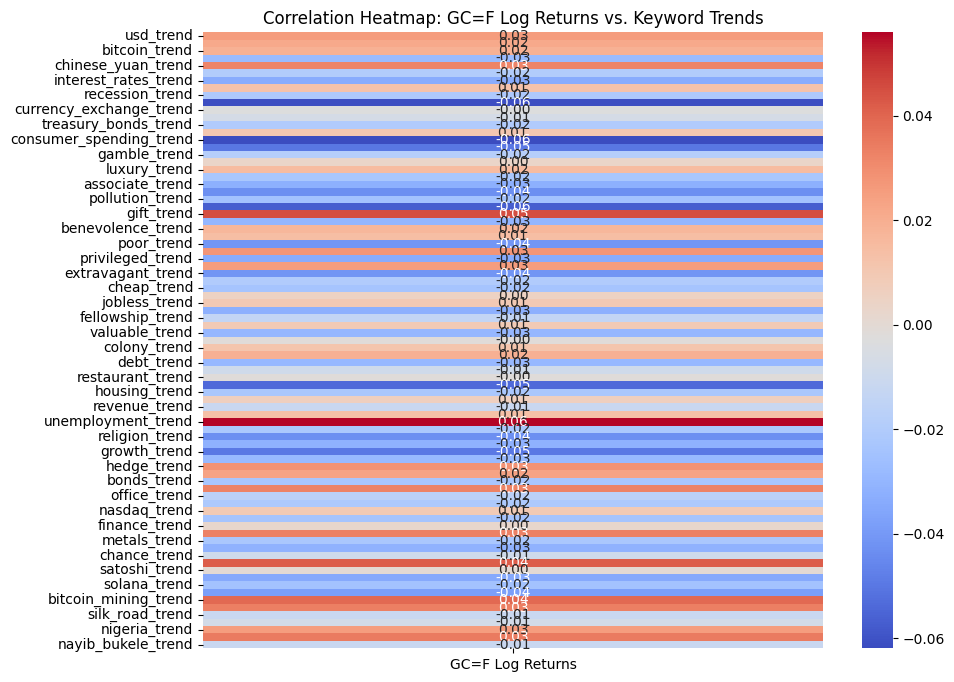


--- Linear Regression (Example with 'gold_price_trend') ---
                            OLS Regression Results                            
Dep. Variable:       GC=F Log Returns   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.6622
Date:                Sun, 07 Sep 2025   Prob (F-statistic):              0.416
Time:                        02:48:13   Log-Likelihood:                 4725.5
No. Observations:                1436   AIC:                            -9447.
Df Residuals:                    1434   BIC:                            -9437.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

,Lag 1,Lag 2,Lag 3,Lag 4,Lag 5
usd,0.015679,0.024280,0.017866,0.014117,0.028910
gold_price,0.013480,0.012153,0.008460,0.013826,0.009959
bitcoin,0.004402,0.012323,0.014549,0.022951,0.034537
oil_price,-0.032806,-0.030237,-0.048640,-0.042795,-0.034606
chinese_yuan,0.040204,0.029420,0.013684,0.036358,0.032976
...,...,...,...,...,...
silk_road,-0.020122,-0.011215,-0.009860,-0.005449,-0.016432
tor,-0.014966,0.009423,0.005040,-0.006997,0.023131
nigeria,0.030073,0.028293,0.033892,0.015135,0.037978
legal_tender,0.024551,0.012557,0.021727,0.001137,0.012582



--- Keywords with Significant Lagged Correlation (|r| > 0.05) for GC=F ---


,Pair,Keyword,Correlation,trading lag
0,GC=F,economic_growth,-0.070,1 day
1,GC=F,economic_growth,-0.075,2 day
2,GC=F,economic_growth,-0.061,3 day
3,GC=F,economic_growth,-0.070,4 day
4,GC=F,economic_growth,-0.060,5 day
5,GC=F,consumer_spending,-0.053,1 day
6,GC=F,consumer_spending,-0.050,2 day
7,GC=F,consumer_spending,-0.068,4 day
8,GC=F,consumer_spending,-0.053,5 day
9,GC=F,intervention,-0.071,2 day


[skip] Significant correlations file already exists in Google Drive: gcf_significant_lagged_correlations.csv


In [61]:
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from googleapiclient.discovery import build
from googleapiclient.http import MediaFileUpload

# Define the Google Drive folder ID for the filtered data
filtered_folder_id = '1lQQLKf8FRlt0wmu91-MyOYER40o3Oej1' # User specified folder ID

# Ensure 'merged' dataframe is available and not empty
if 'merged' in locals() and not merged.empty:
    print("Starting analysis with the merged dataframe.")

    # --- Prepare GC=F specific dataframe including all trends ---
    gcf_specific_columns = [col for col in merged.columns if 'GC=F' in col]
    trend_columns = [col for col in merged.columns if col.endswith('_trend')]
    df_gcf = merged[gcf_specific_columns + trend_columns].copy()
    print("\nCreated GC=F specific dataframe including all trends.")
    display(df_gcf.head())

    # --- Calculate and display the correlation of 'GC=F Log Returns' with Keyword Trends ---
    # Drop rows with NaN values from df_gcf for correlation calculation
    df_gcf_cleaned = df_gcf.dropna().copy()

    print("\nShape of the GC=F dataframe after dropping rows with NaN for correlation:")
    print(df_gcf_cleaned.shape)

    gcf_log_returns_column = 'GC=F Log Returns'

    if gcf_log_returns_column in df_gcf_cleaned.columns:
        gcf_log_returns_correlation = df_gcf_cleaned.corr()[gcf_log_returns_column]

        # Filter to show only correlations with trend columns
        trend_correlations = gcf_log_returns_correlation[gcf_log_returns_correlation.index.str.endswith('_trend')]


        print("\nCorrelation of 'GC=F Log Returns' with Keyword Trends:")
        display(trend_correlations.sort_values(ascending=False))

        # Create a heatmap of the correlations between GC=F Log Returns and trend columns
        if not trend_correlations.empty:
            plt.figure(figsize=(10, 8)) # Adjust figure size for better readability
            sns.heatmap(trend_correlations.to_frame(), annot=True, cmap='coolwarm', fmt=".2f")
            plt.title('Correlation Heatmap: GC=F Log Returns vs. Keyword Trends')
            plt.show()
        else:
            print("\nNo trend correlations to display heatmap for (trend_correlations is empty).")

    else:
        print("\n'GC=F Log Returns' column not found in the cleaned GC=F DataFrame.")


else:
    print("\nCombined dataframe is empty or not found, cannot perform correlation analysis.")
    df_gcf = pd.DataFrame()

# --- Linear Regression ---
print("\n--- Linear Regression (Example with 'gold_price_trend') ---")

# Drop rows with NaN values for the specific columns needed for regression
# (df_gcf_cleaned was already created and NaNs dropped in the previous cell)
# We'll use df_gcf_cleaned directly

# Define dependent and independent variables
# Using 'gold_price_trend' as an example predictor
if 'GC=F Log Returns' in df_gcf_cleaned.columns and 'gold_price_trend' in df_gcf_cleaned.columns:
    y = df_gcf_cleaned['GC=F Log Returns']
    X = df_gcf_cleaned['gold_price_trend']

    # Add a constant to the independent variable for the intercept
    X = sm.add_constant(X)

    # Fit the linear regression model
    model = sm.OLS(y, X).fit()

    # Print the regression summary
    print(model.summary())
else:
    print("Required columns for linear regression not found in df_gcf_cleaned.")

print("\n--- Lagged Correlations ---")

# Calculate lagged correlations for all keyword trends
lag_periods = 5 # Check correlations for lags up to 5 days

# Get all keyword trend columns
all_trend_keywords = [col for col in df_gcf_cleaned.columns if col.endswith('_trend')]

keywords_with_significant_lagged_correlation = []
lagged_correlations_list = [] # List to store lagged correlations for each keyword

for keyword in all_trend_keywords:
    if 'GC=F Log Returns' in df_gcf_cleaned.columns:
        lagged_correlations = {}
        has_significant_lag = False
        for lag in range(1, lag_periods + 1):
            # Shift the trend data by the lag period (lagged trend data)
            lagged_trend = df_gcf_cleaned[keyword].shift(lag)

            # Calculate correlation between GC=F Log Returns and lagged trend
            correlation = df_gcf_cleaned['GC=F Log Returns'].corr(lagged_trend)
            lagged_correlations[f"Lag {lag}"] = correlation

            # Check for significant correlation (using 0.05 threshold)
            if pd.notna(correlation) and abs(correlation) > 0.05:
                has_significant_lag = True

        # Append the lagged correlations for the current keyword to the list
        lagged_correlations_list.append(pd.Series(lagged_correlations, name=keyword.replace('_trend', '')))


        if has_significant_lag:
            keywords_with_significant_lagged_correlation.append(keyword)

    else:
        print(f"\nRequired columns for lagged correlation with '{keyword}' not found in df_gcf_cleaned.")

# Combine all lagged correlations into a single DataFrame
if lagged_correlations_list:
    all_lagged_correlations_df = pd.concat(lagged_correlations_list, axis=1).T
    print("\nLagged Correlations (GC=F Log Returns vs. Keyword Trends):")
    display(all_lagged_correlations_df)
else:
    print("\nNo lagged correlations to display.")


print("\n--- Keywords with Significant Lagged Correlation (|r| > 0.05) for GC=F ---")
export_data = []
if keywords_with_significant_lagged_correlation:
    for keyword in keywords_with_significant_lagged_correlation:
        keyword_name = keyword.replace('_trend', '')
        for lag in range(1, lag_periods + 1):
            correlation_value = all_lagged_correlations_df.loc[keyword_name, f"Lag {lag}"]
            if pd.notna(correlation_value) and abs(correlation_value) > 0.05:
                 export_data.append({
                     'Pair': 'GC=F',
                     'Keyword': keyword_name,
                     'Correlation': f"{correlation_value:.3f}",
                     'trading lag': f"{lag} day"
                 })
    export_df = pd.DataFrame(export_data)
    display(export_df)

else:
    print("No keywords found with absolute lagged correlation greater than 0.05 at any lag period for GC=F.")
    export_df = pd.DataFrame(columns=['Pair', 'Keyword', 'Correlation', 'trading lag']) # Create empty DataFrame if no significant correlations

# --- Export export_df to Google Drive ---
gcf_sig_corr_filename = "gcf_significant_lagged_correlations.csv"
gcf_sig_corr_filepath_local = f"/content/{gcf_sig_corr_filename}" # Save locally first

# Check if the file already exists in the specified Google Drive folder
try:
    # Authenticate and build the Drive service (assuming it's already mounted)
    try:
        drive_service = build('drive', 'v3')
    except Exception as e:
        print(f"Error building Google Drive service: {e}")
        drive_service = None # Ensure drive_service is None if build fails

    if drive_service:
        file_list_gcf_sig_corr = drive_service.files().list(
            q=f"name='{gcf_sig_corr_filename}' and '{filtered_folder_id}' in parents",
            spaces='drive',
            fields='files(id, name)'
        ).execute().get('files', [])

        if file_list_gcf_sig_corr:
            print(f"[skip] Significant correlations file already exists in Google Drive: {gcf_sig_corr_filename}")
        else:
            # Save the DataFrame to a temporary local CSV file
            export_df.to_csv(gcf_sig_corr_filepath_local, index=False)

            # Create a file in the shared drive using the Google Drive API
            file_metadata_gcf_sig_corr = {
                'name': gcf_sig_corr_filename,
                'parents': [filtered_folder_id]
            }

            media_gcf_sig_corr = MediaFileUpload(gcf_sig_corr_filepath_local, mimetype='text/csv')

            gfile_gcf_sig_corr = drive_service.files().create(
                body=file_metadata_gcf_sig_corr,
                media_body=media_gcf_sig_corr,
                fields='id'
            ).execute()

            print(f"Significant Correlations File ID: {gfile_gcf_sig_corr.get('id')}")
            print(f"Significant GC=F correlations data exported to shared drive folder: {filtered_folder_id}")

            # Clean up the local file
            os.remove(gcf_sig_corr_filepath_local)
    else:
        print("Google Drive service not available. Cannot export significant correlations.")

except Exception as e:
    print(f"Error exporting significant GC=F correlations data to shared drive: {e}")
    # Clean up local file if it exists after an error
    if os.path.exists(gcf_sig_corr_filepath_local):
        os.remove(gcf_sig_corr_filepath_local)

Starting analysis with the merged dataframe.

Created CL=F specific dataframe including all trends.


,CL=F Close,CL=F Open,CL=F High,CL=F Low,CL=F 20-day simple moving average,CL=F 14-day RSI,CL=F Log Returns,CL=F 30-day Rolling Volatility,usd_trend,gold_price_trend,...,el_salvador_trend,solana_trend,tesla_trend,bitcoin_mining_trend,blockchain_trend,silk_road_trend,tor_trend,nigeria_trend,legal_tender_trend,nayib_bukele_trend
Date,,,,,,,,,,,,,,,,,,,,,
2015-09-08,45.939999,45.820000,46.410000,44.139999,45.939999,NaN,NaN,NaN,93,52,...,54,80,29,35,39,54,72,58,44,0
2015-09-09,44.150002,45.790001,46.259998,44.049999,45.045,0.000000,-0.039743,NaN,92,50,...,52,73,28,36,44,56,73,58,52,0
2015-09-10,45.919998,44.160000,46.040001,43.360001,45.336666,49.719094,0.039308,0.055900,91,59,...,45,69,31,38,47,60,74,54,59,27
2015-09-11,44.630001,45.709999,45.880001,44.160000,45.16,36.494845,-0.028494,0.042850,83,52,...,41,74,32,33,39,57,72,58,47,0
2015-09-14,44.000000,44.779999,44.970001,43.590000,44.928,32.299256,-0.014217,0.035081,85,51,...,41,80,29,36,42,66,94,56,57,0



Shape of the CL=F dataframe after dropping rows with NaN for correlation:
(1434, 91)

Correlation of 'CL=F Log Returns' with Keyword Trends:


,CL=F Log Returns
bargain_trend,0.069982
inexpensive_trend,0.059202
poor_trend,0.052438
extravagant_trend,0.041737
growth_trend,0.039687
...,...
dow_jones_trend,-0.068499
gold_trend,-0.072124
gold_price_trend,-0.073397
recession_trend,-0.081446


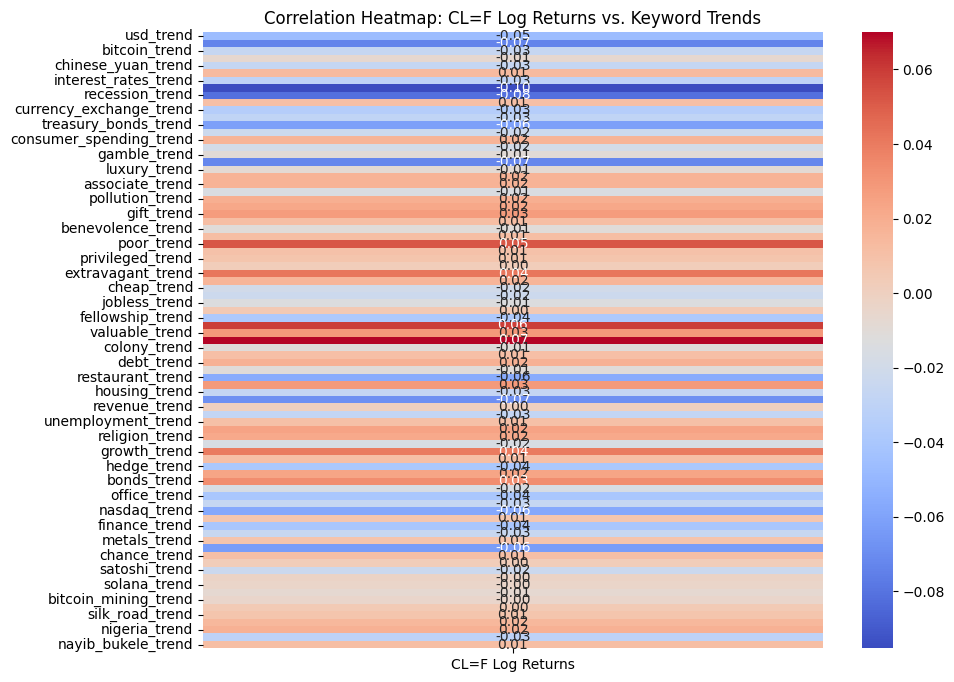


--- Linear Regression (Example with 'oil_price_trend') ---
                            OLS Regression Results                            
Dep. Variable:       CL=F Log Returns   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.05731
Date:                Sun, 07 Sep 2025   Prob (F-statistic):              0.811
Time:                        02:48:15   Log-Likelihood:                 2962.5
No. Observations:                1434   AIC:                            -5921.
Df Residuals:                    1432   BIC:                            -5910.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

,Lag 1,Lag 2,Lag 3,Lag 4,Lag 5
usd,-0.047036,-0.041667,-0.042493,-0.038634,-0.038407
gold_price,-0.064887,-0.051580,-0.049696,-0.055569,-0.044844
bitcoin,-0.038252,-0.049335,-0.043374,-0.016423,-0.032630
oil_price,0.003177,-0.013397,-0.015256,-0.011526,-0.003397
chinese_yuan,-0.039546,-0.021704,-0.002625,-0.023874,-0.033821
...,...,...,...,...,...
silk_road,-0.000566,-0.016644,-0.016989,-0.024755,-0.020186
tor,0.048012,0.026744,0.031072,0.043125,0.039911
nigeria,0.038634,0.030564,0.021351,0.025724,0.028137
legal_tender,-0.016283,-0.026157,-0.022763,-0.029808,-0.031129



--- Keywords with Significant Lagged Correlation (|r| > 0.05) for CL=F ---


,Pair,Keyword,Correlation,trading lag
0,CL=F,gold_price,-0.065,1 day
1,CL=F,gold_price,-0.052,2 day
2,CL=F,gold_price,-0.056,4 day
3,CL=F,recession,-0.057,1 day
4,CL=F,commodity_prices,-0.074,2 day
5,CL=F,commodity_prices,-0.053,3 day
6,CL=F,commodity_prices,-0.054,4 day
7,CL=F,treasury_bonds,-0.058,4 day
8,CL=F,intervention,-0.060,4 day
9,CL=F,gold,-0.088,1 day


[skip] Significant correlations file already exists in Google Drive: clf_significant_lagged_correlations.csv


In [62]:
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from googleapiclient.discovery import build
from googleapiclient.http import MediaFileUpload

# Define the Google Drive folder ID for the filtered data
filtered_folder_id = '1lQQLKf8FRlt0wmu91-MyOYER40o3Oej1' # User specified folder ID

# Ensure 'merged' dataframe is available and not empty
if 'merged' in locals() and not merged.empty:
    print("Starting analysis with the merged dataframe.")

    # --- Prepare CL=F specific dataframe including all trends ---
    clf_specific_columns = [col for col in merged.columns if 'CL=F' in col]
    trend_columns = [col for col in merged.columns if col.endswith('_trend')]
    df_clf = merged[clf_specific_columns + trend_columns].copy()
    print("\nCreated CL=F specific dataframe including all trends.")
    display(df_clf.head())

    # --- Calculate and display the correlation of 'CL=F Log Returns' with Keyword Trends ---
    # Drop rows with NaN values from df_clf for correlation calculation
    df_clf_cleaned = df_clf.dropna().copy()

    print("\nShape of the CL=F dataframe after dropping rows with NaN for correlation:")
    print(df_clf_cleaned.shape)

    clf_log_returns_column = 'CL=F Log Returns'

    if clf_log_returns_column in df_clf_cleaned.columns:
        clf_log_returns_correlation = df_clf_cleaned.corr()[clf_log_returns_column]

        # Filter to show only correlations with trend columns
        trend_correlations = clf_log_returns_correlation[clf_log_returns_correlation.index.str.endswith('_trend')]


        print("\nCorrelation of 'CL=F Log Returns' with Keyword Trends:")
        display(trend_correlations.sort_values(ascending=False))

        # Create a heatmap of the correlations between CL=F Log Returns and trend columns
        if not trend_correlations.empty:
            plt.figure(figsize=(10, 8)) # Adjust figure size for better readability
            sns.heatmap(trend_correlations.to_frame(), annot=True, cmap='coolwarm', fmt=".2f")
            plt.title('Correlation Heatmap: CL=F Log Returns vs. Keyword Trends')
            plt.show()
        else:
            print("\nNo trend correlations to display heatmap for (trend_correlations is empty).")

    else:
        print("\n'CL=F Log Returns' column not found in the cleaned CL=F DataFrame.")


else:
    print("\nCombined dataframe is empty or not found, cannot perform correlation analysis.")
    df_clf = pd.DataFrame()


# --- Linear Regression ---
print("\n--- Linear Regression (Example with 'oil_price_trend') ---")

# Drop rows with NaN values for the specific columns needed for regression
# (df_clf_cleaned was already created and NaNs dropped in the previous cell)
# We'll use df_clf_cleaned directly

# Define dependent and independent variables
# Using 'oil_price_trend' as an example predictor
if 'CL=F Log Returns' in df_clf_cleaned.columns and 'oil_price_trend' in df_clf_cleaned.columns:
    y = df_clf_cleaned['CL=F Log Returns']
    X = df_clf_cleaned['oil_price_trend']

    # Add a constant to the independent variable for the intercept
    X = sm.add_constant(X)

    # Fit the linear regression model
    model = sm.OLS(y, X).fit()

    # Print the regression summary
    print(model.summary())
else:
    print("Required columns for linear regression not found in df_clf_cleaned.")


print("\n--- Lagged Correlations ---")

# Calculate lagged correlations for all keyword trends
lag_periods = 5 # Check correlations for lags up to 5 days

# Get all keyword trend columns
all_trend_keywords = [col for col in df_clf_cleaned.columns if col.endswith('_trend')]

keywords_with_significant_lagged_correlation = []
lagged_correlations_list = [] # List to store lagged correlations for each keyword


for keyword in all_trend_keywords:
    if 'CL=F Log Returns' in df_clf_cleaned.columns:
        lagged_correlations = {}
        has_significant_lag = False
        for lag in range(1, lag_periods + 1):
            # Shift the trend data by the lag period (lagged trend data)
            lagged_trend = df_clf_cleaned[keyword].shift(lag)

            # Calculate correlation between CL=F Log Returns and lagged trend
            correlation = df_clf_cleaned['CL=F Log Returns'].corr(lagged_trend)
            lagged_correlations[f"Lag {lag}"] = correlation

            # Check for significant correlation (using 0.05 threshold)
            if pd.notna(correlation) and abs(correlation) > 0.05:
                has_significant_lag = True

        # Append the lagged correlations for the current keyword to the list
        lagged_correlations_list.append(pd.Series(lagged_correlations, name=keyword.replace('_trend', '')))


        if has_significant_lag:
            keywords_with_significant_lagged_correlation.append(keyword)

    else:
        print(f"\nRequired columns for lagged correlation with '{keyword}' not found in df_clf_cleaned.")

# Combine all lagged correlations into a single DataFrame
if lagged_correlations_list:
    all_lagged_correlations_df = pd.concat(lagged_correlations_list, axis=1).T
    print("\nLagged Correlations (CL=F Log Returns vs. Keyword Trends):")
    display(all_lagged_correlations_df)
else:
    print("\nNo lagged correlations to display.")


print("\n--- Keywords with Significant Lagged Correlation (|r| > 0.05) for CL=F ---")
export_data = []
if keywords_with_significant_lagged_correlation:
    for keyword in keywords_with_significant_lagged_correlation:
        keyword_name = keyword.replace('_trend', '')
        for lag in range(1, lag_periods + 1):
            correlation_value = all_lagged_correlations_df.loc[keyword_name, f"Lag {lag}"]
            if pd.notna(correlation_value) and abs(correlation_value) > 0.05:
                 export_data.append({
                     'Pair': 'CL=F',
                     'Keyword': keyword_name,
                     'Correlation': f"{correlation_value:.3f}",
                     'trading lag': f"{lag} day"
                 })
    export_df = pd.DataFrame(export_data)
    display(export_df)

else:
    print("No keywords found with absolute lagged correlation greater than 0.05 at any lag period for CL=F.")
    export_df = pd.DataFrame(columns=['Pair', 'Keyword', 'Correlation', 'trading lag']) # Create empty DataFrame if no significant correlations


# --- Export export_df to Google Drive ---
clf_sig_corr_filename = "clf_significant_lagged_correlations.csv"
clf_sig_corr_filepath_local = f"/content/{clf_sig_corr_filename}" # Save locally first

# Check if the file already exists in the specified Google Drive folder
try:
    # Authenticate and build the Drive service (assuming it's already mounted)
    try:
        drive_service = build('drive', 'v3')
    except Exception as e:
        print(f"Error building Google Drive service: {e}")
        drive_service = None # Ensure drive_service is None if build fails

    if drive_service:
        file_list_clf_sig_corr = drive_service.files().list(
            q=f"name='{clf_sig_corr_filename}' and '{filtered_folder_id}' in parents",
            spaces='drive',
            fields='files(id, name)'
        ).execute().get('files', [])

        if file_list_clf_sig_corr:
            print(f"[skip] Significant correlations file already exists in Google Drive: {clf_sig_corr_filename}")
        else:
            # Save the DataFrame to a temporary local CSV file
            export_df.to_csv(clf_sig_corr_filepath_local, index=False)

            # Create a file in the shared drive using the Google Drive API
            file_metadata_clf_sig_corr = {
                'name': clf_sig_corr_filename,
                'parents': [filtered_folder_id]
            }

            media_clf_sig_corr = MediaFileUpload(clf_sig_corr_filepath_local, mimetype='text/csv')

            gfile_clf_sig_corr = drive_service.files().create(
                body=file_metadata_clf_sig_corr,
                media_body=media_clf_sig_corr,
                fields='id'
            ).execute()

            print(f"Significant Correlations File ID: {gfile_clf_sig_corr.get('id')}")
            print(f"Significant CL=F correlations data exported to shared drive folder: {filtered_folder_id}")

            # Clean up the local file
            os.remove(clf_sig_corr_filepath_local)
    else:
        print("Google Drive service not available. Cannot export significant correlations.")

except Exception as e:
    print(f"Error exporting significant CL=F correlations data to shared drive: {e}")
    # Clean up local file if it exists after an error
    if os.path.exists(clf_sig_corr_filepath_local):
        os.remove(clf_sig_corr_filepath_local)

**Reasoning**:
Display the head of the combined DataFrame to verify the data.



In [66]:
import os
from google.colab import drive
from google.colab import auth
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload
import pandas as pd

# Define the Google Drive folder ID where the individual keyword trends CSVs are stored
keyword_folder_id = '1lQQLKf8FRlt0wmu91-MyOYER40o3Oej1' # User specified folder ID for keyword CSVs

# Authenticate and mount Google Drive
# Check if Google Drive is already mounted
if not os.path.exists('/content/drive'):
    try:
        drive.mount('/content/drive', force_remount=True)
        print("Google Drive mounted successfully.")
    except Exception as e:
        print(f"Error mounting Google Drive: {e}")
        # If mounting fails, we cannot proceed with Drive operations
        drive_service = None
        print("Google Drive service not available. Cannot proceed with file operations.")
        # Skip the rest of the cell if drive_service is None
        # Continue to the end of the cell where combined_trends_df might be initialized as empty
    else:
        # If mounting was successful, authenticate and build the service
        try:
            auth.authenticate_user()
            drive_service = build('drive', 'v3')
            print("Google Drive service built successfully after mounting.")
        except Exception as e:
            print(f"Error authenticating or building Google Drive service after mounting: {e}")
            drive_service = None
            print("Google Drive service not available. Cannot proceed with file operations.")

else:
    print("Google Drive is already mounted.")
    # If already mounted, just authenticate and build the service
    try:
        auth.authenticate_user()
        drive_service = build('drive', 'v3')
        print("Google Drive service built successfully (already mounted).")
    except Exception as e:
        print(f"Error authenticating or building Google Drive service (already mounted): {e}")
        drive_service = None
        print("Google Drive service not available. Cannot proceed with file operations.")


# Proceed with file operations only if drive_service is available
if drive_service:
    # List all files within this folder
    try:
        all_files_list = drive_service.files().list(
            q=f"'{keyword_folder_id}' in parents",
            spaces='drive',
            fields='files(id, name)'
        ).execute().get('files', [])
    except Exception as e:
        print(f"Error listing files in Google Drive folder: {e}")
        # If listing files fails, we cannot proceed with processing them
        all_files_list = [] # Set file_list to empty if error occurs
        print("Cannot proceed with file operations due to listing error.")

    # Filter the files to include only keyword trends CSVs and exclude significant correlations files
    file_list = [
        file_info for file_info in all_files_list
        if '_daily.csv' in file_info['name'] and '_significant_lagged_correlations.csv' not in file_info['name']
    ]

    # Initialize an empty list to store DataFrames
    dataframes_list = []

    # Iterate through the list of filtered CSV files
    if file_list:
        print(f"Found {len(file_list)} keyword trends CSV files in the specified Google Drive folder.")
        for file_info in file_list:
            file_id = file_info['id']
            file_name = file_info['name']
            local_file_path = f"/content/{file_name}" # Temporary local path

            print(f"Downloading {file_name}...")
            request = drive_service.files().get_media(fileId=file_id)
            try:
                with open(local_file_path, 'wb') as f:
                    downloader = MediaIoBaseDownload(f, request)
                    done = False
                    while done is False:
                        status, done = downloader.next_chunk()
                        # print(f"Download {int(status.progress() * 100)}%.") # Optional: print progress
                print(f"Successfully downloaded {file_name}.")

                # Read the local CSV file into a pandas DataFrame
                # Assuming the date is in the first column and is the index
                df = pd.read_csv(local_file_path, index_col=0, parse_dates=True)

                # Append the DataFrame to the list of DataFrames
                dataframes_list.append(df)

                # Delete the temporary local CSV file
                os.remove(local_file_path)
                print(f"Removed temporary local file: {local_file_path}")

            except Exception as e:
                print(f"Error processing file {file_name}: {e}")
                # Clean up local file if it exists after an error
                if os.path.exists(local_file_path):
                    os.remove(local_file_path)


    else:
        print("No keyword trends CSV files found in the specified Google Drive folder after filtering.")

    # Concatenate all DataFrames in the list into a single DataFrame
    if dataframes_list:
        combined_trends_df = pd.concat(dataframes_list, axis=1).sort_index()
        print("\nCombined Keyword Trends DataFrame created successfully.")
        # Display the head of the combined DataFrame
        display(combined_trends_df.head())
    else:
        print("\nNo dataframes were combined as no files were processed successfully.")
        combined_trends_df = pd.DataFrame() # Initialize as empty DataFrame if no files were processed

else:
    # This block is reached if drive_service was not available after authentication attempts
    print("\nCannot proceed with combining data as Google Drive service was not available.")
    combined_trends_df = pd.DataFrame() # Initialize as empty DataFrame

Google Drive is already mounted.
Google Drive service built successfully (already mounted).
Found 1 keyword trends CSV files in the specified Google Drive folder.
Successfully downloaded clf_daily.csv.
Removed temporary local file: /content/clf_daily.csv

Combined Keyword Trends DataFrame created successfully.


,CL=F Close,CL=F Open,CL=F High,CL=F Low,CL=F 20-day simple moving average,CL=F 14-day RSI,CL=F Log Returns,CL=F 30-day Rolling Volatility,usd_trend,gold_price_trend,...,el_salvador_trend,solana_trend,tesla_trend,bitcoin_mining_trend,blockchain_trend,silk_road_trend,tor_trend,nigeria_trend,legal_tender_trend,nayib_bukele_trend
Date,,,,,,,,,,,,,,,,,,,,,
2016-03-08,36.500000,37.939999,38.389999,36.119999,32.0850,75.042866,-0.037639,0.043174,30,32,...,30,64,7,43,55,76,66,46,36,0
2016-03-09,38.290001,36.360001,38.509998,36.240002,32.6270,78.185892,0.047877,0.043730,28,34,...,29,66,6,43,62,67,61,45,64,31
2016-03-10,37.840000,38.169998,38.480000,37.209999,33.2085,82.385450,-0.011822,0.043652,31,31,...,30,74,7,35,66,78,64,44,49,32
2016-03-11,38.500000,37.990002,39.020000,37.919998,33.6615,80.574896,0.017291,0.043692,28,27,...,29,57,7,38,57,69,60,44,37,33
2016-03-14,37.180000,38.169998,38.770000,36.680000,34.0485,71.394025,-0.034887,0.042630,29,32,...,29,71,6,35,63,75,63,45,50,0


In [76]:
import os
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload, MediaFileUpload
import pandas as pd

# Define the Google Drive folder ID where the individual trading pair CSVs are stored and where the combined file will be saved
keyword_folder_id = '1lQQLKf8FRlt0wmu91-MyOYER40o3Oej1' # User specified folder ID for keyword CSVs

# Authenticate and build the Drive service (assuming it's already mounted)
try:
    drive_service = build('drive', 'v3')
except Exception as e:
    print(f"Error building Google Drive service: {e}")
    # Handle the error appropriately if service build fails
    drive_service = None # Ensure drive_service is None if build fails


if drive_service:
    # List all files within this folder ending with '_significant_lagged_correlations.csv'
    try:
        file_list = drive_service.files().list(
            q=f"'{keyword_folder_id}' in parents and name contains '_significant_lagged_correlations.csv'",
            spaces='drive',
            fields='files(id, name)'
        ).execute().get('files', [])
    except Exception as e:
        print(f"Error listing files in Google Drive folder: {e}")
        file_list = [] # Set file_list to empty if error occurs

    # Initialize an empty list to store DataFrames
    dataframes_list = []

    # Iterate through the list of CSV files
    if file_list:
        print(f"Found {len(file_list)} significant correlations CSV files in the specified Google Drive folder.")
        for file_info in file_list:
            file_id = file_info['id']
            file_name = file_info['name']
            local_file_path = f"/content/{file_name}" # Temporary local path

            print(f"Downloading {file_name}...")
            request = drive_service.files().get_media(fileId=file_id)
            try:
                with open(local_file_path, 'wb') as f:
                    downloader = MediaIoBaseDownload(f, request)
                    done = False
                    while done is False:
                        status, done = downloader.next_chunk()
                        # print(f"Download {int(status.progress() * 100)}%.") # Optional: print progress
                print(f"Successfully downloaded {file_name}.")

                # Read the local CSV file into a pandas DataFrame
                df = pd.read_csv(local_file_path)

                # Append the DataFrame to the list of DataFrames
                dataframes_list.append(df)

                # Delete the temporary local CSV file
                os.remove(local_file_path)
                print(f"Removed temporary local file: {local_file_path}")

            except Exception as e:
                print(f"Error processing file {file_name}: {e}")
                # Clean up local file if it exists after an error
                if os.path.exists(local_file_path):
                    os.remove(local_file_path)

    else:
        print("No significant correlations CSV files found in the specified Google Drive folder.")

    # Concatenate all DataFrames in the list into a single DataFrame
    if dataframes_list:
        combined_significant_correlations_df = pd.concat(dataframes_list, ignore_index=True)
        # Removed the line to drop duplicate rows based on user request
        # combined_significant_correlations_df = combined_significant_correlations_df.drop_duplicates()
        print("\nCombined Significant Correlations DataFrame created successfully.")
        # Display all rows of the combined DataFrame
        display(combined_significant_correlations_df)

        # --- Export combined_significant_correlations_df to Google Drive ---
        combined_filename = "combined_significant_lagged_correlations.csv"
        combined_filepath_local = f"/content/{combined_filename}" # Save locally first

        # Check if the file already exists in the specified Google Drive folder
        try:
            file_list_combined = drive_service.files().list(
                q=f"name='{combined_filename}' and '{keyword_folder_id}' in parents",
                spaces='drive',
                fields='files(id, name)'
            ).execute().get('files', [])

            if file_list_combined:
                print(f"[skip] Combined correlations file already exists in Google Drive: {combined_filename}")
            else:
                # Save the DataFrame to a temporary local CSV file
                combined_significant_correlations_df.to_csv(combined_filepath_local, index=False)

                # Create a file in the shared drive using the Google Drive API
                file_metadata_combined = {
                    'name': combined_filename,
                    'parents': [keyword_folder_id]
                }

                media_combined = MediaFileUpload(combined_filepath_local, mimetype='text/csv')

                gfile_combined = drive_service.files().create(
                    body=file_metadata_combined,
                    media_body=media_combined,
                    fields='id'
                ).execute()

                print(f"Combined Correlations File ID: {gfile_combined.get('id')}")
                print(f"Combined significant correlations data exported to shared drive folder: {keyword_folder_id}")

                # Clean up the local file
                os.remove(combined_filepath_local)

        except Exception as e:
            print(f"Error exporting combined significant correlations data to shared drive: {e}")
            # Clean up local file if it exists after an error
            if os.path.exists(combined_filepath_local):
                os.remove(combined_filepath_local)

    else:
        print("\nNo dataframes were combined as no files were processed successfully.")
        combined_significant_correlations_df = pd.DataFrame() # Initialize as empty DataFrame if no files were processed

else:
    print("Google Drive service not available. Cannot proceed with file operations.")
    combined_significant_correlations_df = pd.DataFrame() # Initialize as empty DataFrame if drive service is not available

Found 4 significant correlations CSV files in the specified Google Drive folder.
Successfully downloaded gcf_significant_lagged_correlations.csv.
Removed temporary local file: /content/gcf_significant_lagged_correlations.csv
Successfully downloaded usdcny_x_significant_lagged_correlations.csv.
Removed temporary local file: /content/usdcny_x_significant_lagged_correlations.csv
Successfully downloaded btc_usd_significant_lagged_correlations.csv.
Removed temporary local file: /content/btc_usd_significant_lagged_correlations.csv
Successfully downloaded clf_significant_lagged_correlations.csv.
Removed temporary local file: /content/clf_significant_lagged_correlations.csv

Combined Significant Correlations DataFrame created successfully.


,Pair,Keyword,Correlation,trading lag
0,GC=F,economic_growth,-0.070,1 day
1,GC=F,economic_growth,-0.075,2 day
2,GC=F,economic_growth,-0.061,3 day
3,GC=F,economic_growth,-0.070,4 day
4,GC=F,economic_growth,-0.060,5 day
...,...,...,...,...
192,CL=F,travel,-0.084,2 day
193,CL=F,travel,-0.084,3 day
194,CL=F,travel,-0.094,4 day
195,CL=F,travel,-0.059,5 day


Combined Correlations File ID: 1qNibbNyj-Zj58Iuim7ohb1RGq7SqODAr
Combined significant correlations data exported to shared drive folder: 1lQQLKf8FRlt0wmu91-MyOYER40o3Oej1


,Pair,Keyword,Correlation,trading lag
36,USDCNY=X,inflation,0.053,4 day
37,USDCNY=X,commodity_prices,0.060,3 day
38,USDCNY=X,commodity_prices,0.056,5 day
39,USDCNY=X,treasury_bonds,0.072,1 day
40,USDCNY=X,treasury_bonds,0.056,2 day
41,USDCNY=X,treasury_bonds,0.082,3 day
42,USDCNY=X,treasury_bonds,0.074,4 day
43,USDCNY=X,treasury_bonds,0.083,5 day
44,USDCNY=X,intervention,0.063,3 day
45,USDCNY=X,intervention,0.068,4 day


In [77]:
import os
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload
import pandas as pd

# Define the Google Drive folder ID where the combined file is stored
keyword_folder_id = '1lQQLKf8FRlt0wmu91-MyOYER40o3Oej1' # User specified folder ID

# Define the filename of the combined file
combined_filename = "combined_significant_lagged_correlations.csv"
combined_filepath_local = f"/content/{combined_filename}" # Temporary local path

# Authenticate and build the Drive service (assuming it's already mounted)
try:
    drive_service = build('drive', 'v3')
except Exception as e:
    print(f"Error building Google Drive service: {e}")
    drive_service = None # Ensure drive_service is None if build fails

if drive_service:
    # Check if the combined file exists in the specified Google Drive folder
    try:
        file_list_combined = drive_service.files().list(
            q=f"name='{combined_filename}' and '{keyword_folder_id}' in parents",
            spaces='drive',
            fields='files(id, name)'
        ).execute().get('files', [])

        if file_list_combined:
            file_id_combined = file_list_combined[0]['id']
            print(f"Found combined correlations file in Google Drive: {combined_filename}")

            # Download the combined file
            print(f"Downloading {combined_filename}...")
            request = drive_service.files().get_media(fileId=file_id_combined)
            try:
                with open(combined_filepath_local, 'wb') as f:
                    downloader = MediaIoBaseDownload(f, request)
                    done = False
                    while done is False:
                        status, done = downloader.next_chunk()
                        # print(f"Download {int(status.progress() * 100)}%.") # Optional: print progress
                print(f"Successfully downloaded {combined_filename}.")

                # Read the combined CSV file into a pandas DataFrame
                combined_significant_correlations_df = pd.read_csv(combined_filepath_local)

                # Delete the temporary local CSV file
                os.remove(combined_filepath_local)
                print(f"Removed temporary local file: {combined_filepath_local}")

                # --- Pivot the table ---
                # The user wants 'trading lag' as index, 'Keyword' as columns,
                # and correlation values for each Pair.
                # This requires unstacking after setting index.
                # We need to ensure the data is in a format suitable for pivoting.
                # The current combined_significant_correlations_df has columns
                # 'Pair', 'Keyword', 'Correlation', 'trading lag'.

                # Set 'trading lag' and 'Keyword' as index
                pivot_df = combined_significant_correlations_df.set_index(['trading lag', 'Keyword', 'Pair'])['Correlation']

                # Unstack by 'Pair' to get Pairs as columns
                pivot_df = pivot_df.unstack(level='Pair')

                # Fill any null values with 0
                pivot_df = pivot_df.fillna(0)

                print("\nPivoted and cleaned DataFrame:")
                display(pivot_df)

            except Exception as e:
                print(f"Error processing combined file {combined_filename}: {e}")
                # Clean up local file if it exists after an error
                if os.path.exists(combined_filepath_local):
                    os.remove(combined_filepath_local)
                pivot_df = pd.DataFrame() # Initialize as empty DataFrame on error


        else:
            print(f"Combined correlations file not found in Google Drive: {combined_filename}")
            pivot_df = pd.DataFrame() # Initialize as empty DataFrame

    except Exception as e:
        print(f"Error accessing Google Drive to check for combined file: {e}")
        pivot_df = pd.DataFrame() # Initialize as empty DataFrame


else:
    print("Google Drive service not available. Cannot proceed with file operations.")
    pivot_df = pd.DataFrame() # Initialize as empty DataFrame

Found combined correlations file in Google Drive: combined_significant_lagged_correlations.csv
Successfully downloaded combined_significant_lagged_correlations.csv.
Removed temporary local file: /content/combined_significant_lagged_correlations.csv

Pivoted and cleaned DataFrame:


Pair                        BTC-USD   CL=F   GC=F  USDCNY=X
trading lag Keyword                                        
1 day       affluent         -0.082  0.000  0.000     0.000
            bargain           0.052  0.051  0.000     0.000
            bitcoin          -0.071  0.000  0.000     0.000
            bitcoin_mining   -0.083  0.000  0.000     0.000
            blockchain       -0.106  0.000  0.000     0.000
...                             ...    ...    ...       ...
5 day       satoshi          -0.059  0.000  0.000     0.000
            silk_road        -0.063  0.000  0.000     0.072
            travel            0.000 -0.059  0.000     0.052
            treasury_bonds    0.000  0.000  0.000     0.083
            valuable          0.000  0.000 -0.063     0.000

[171 rows x 4 columns]

Displaying pivot_df as a heatmap in 10 equal parts.


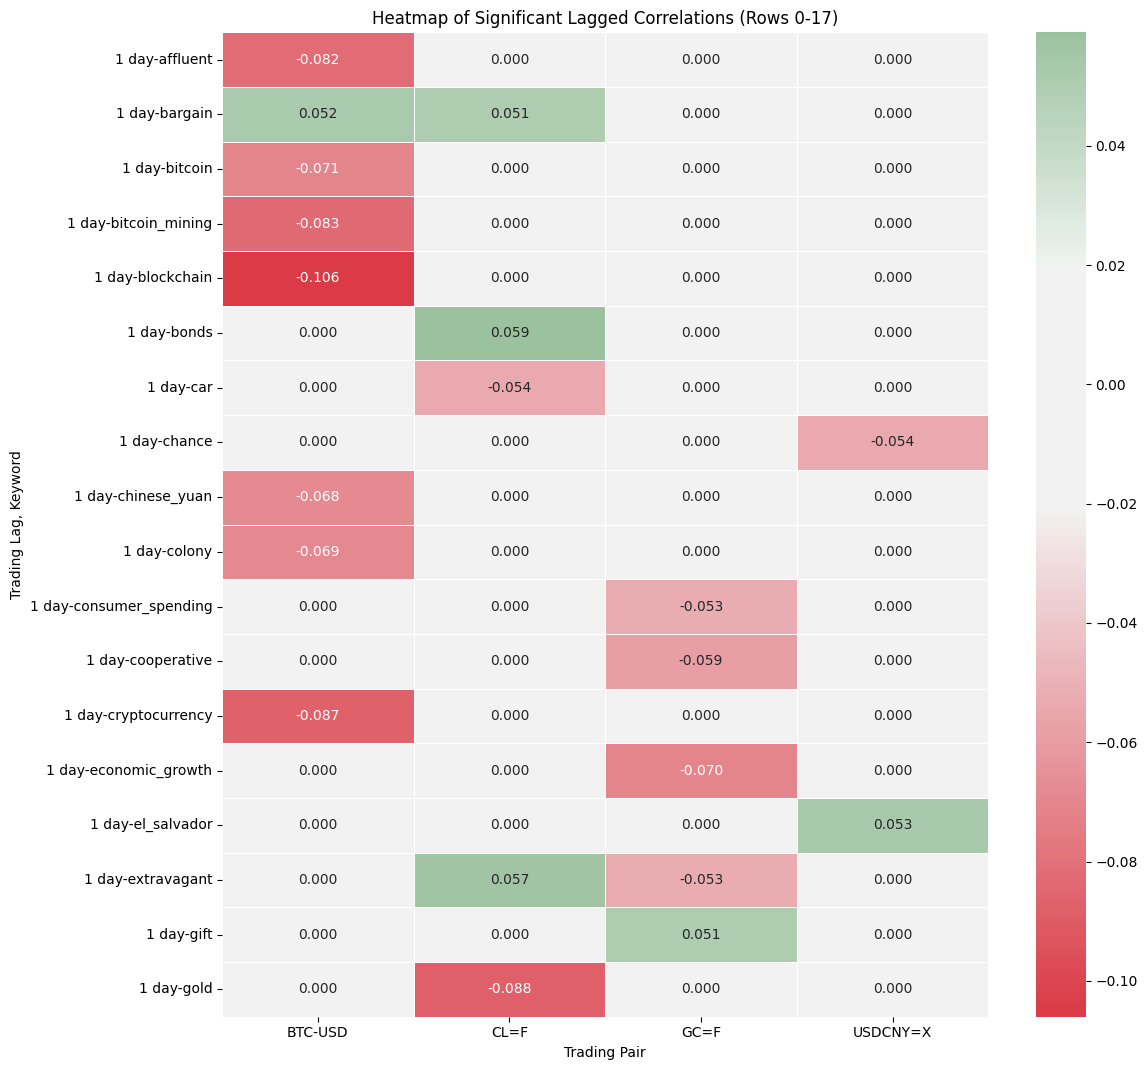

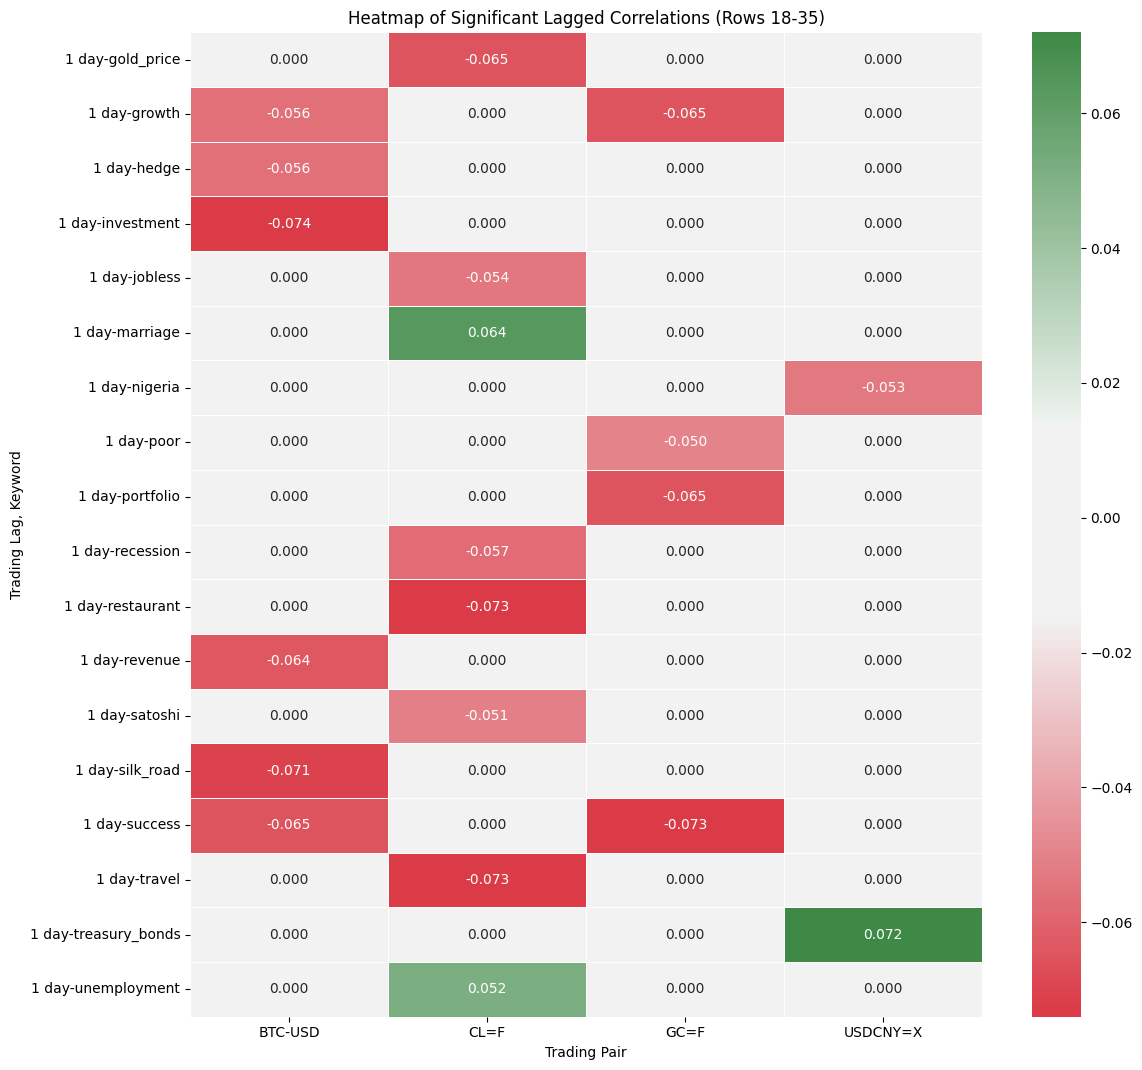

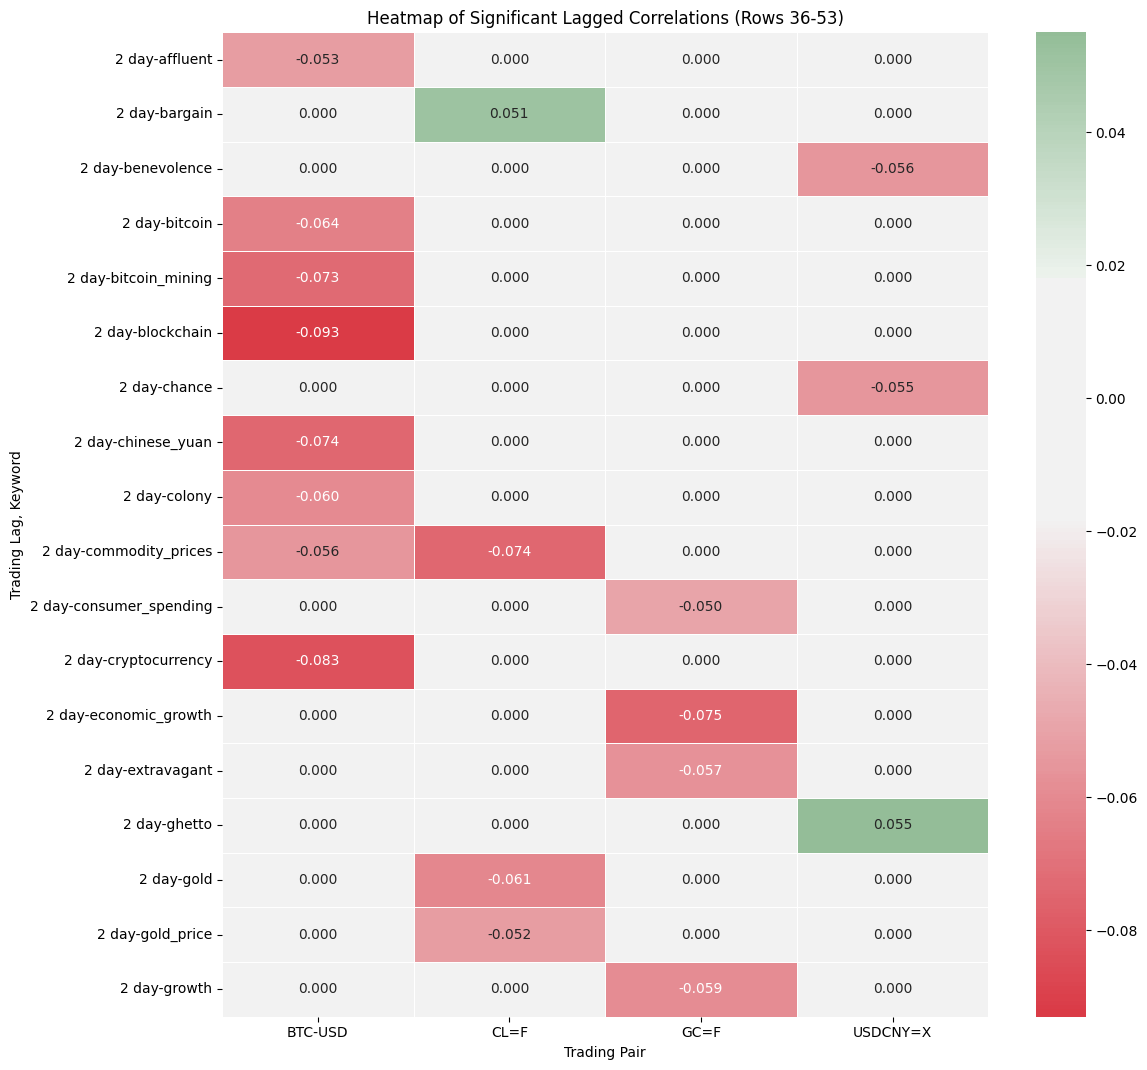

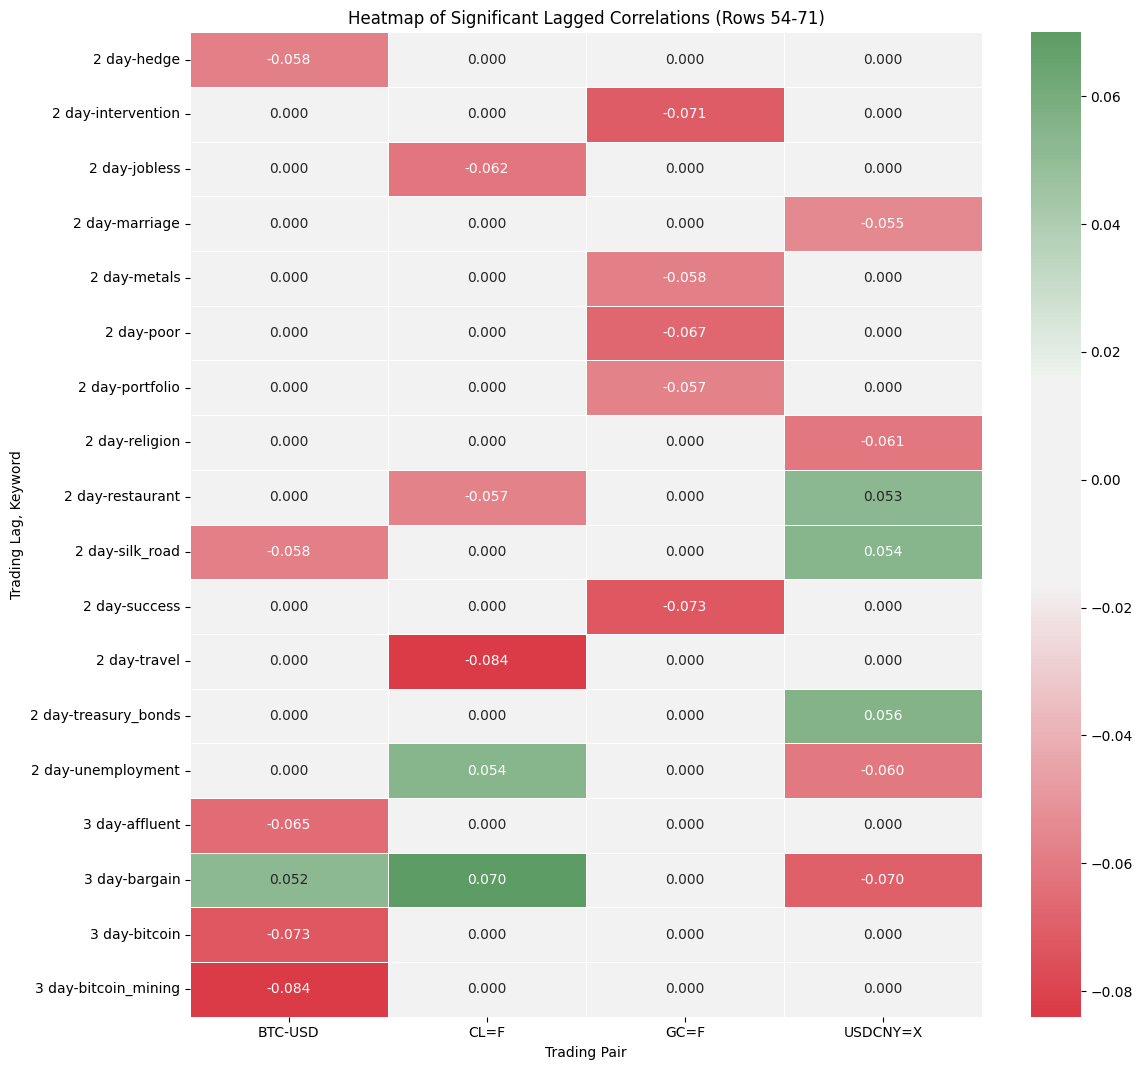

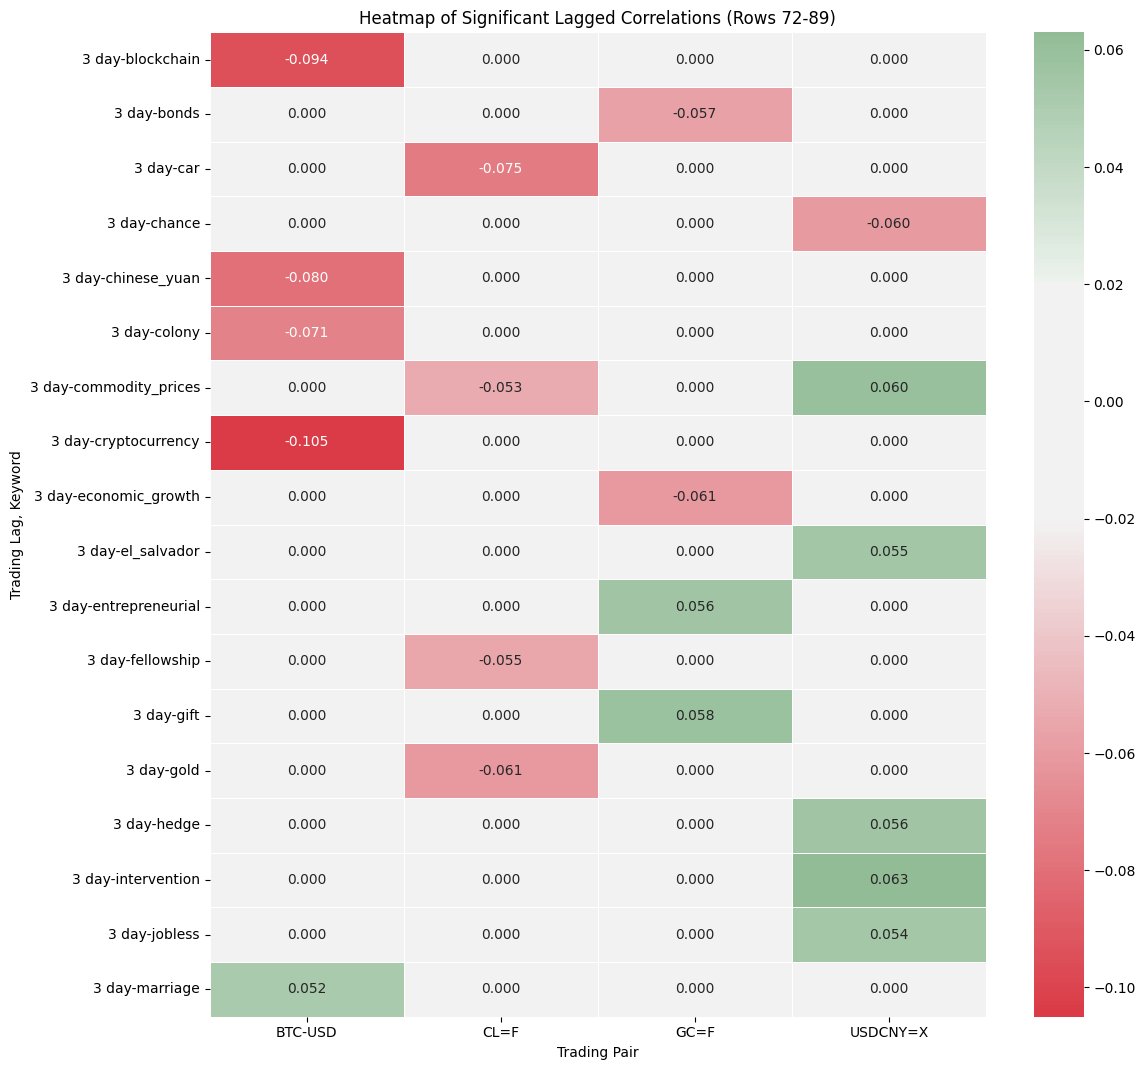

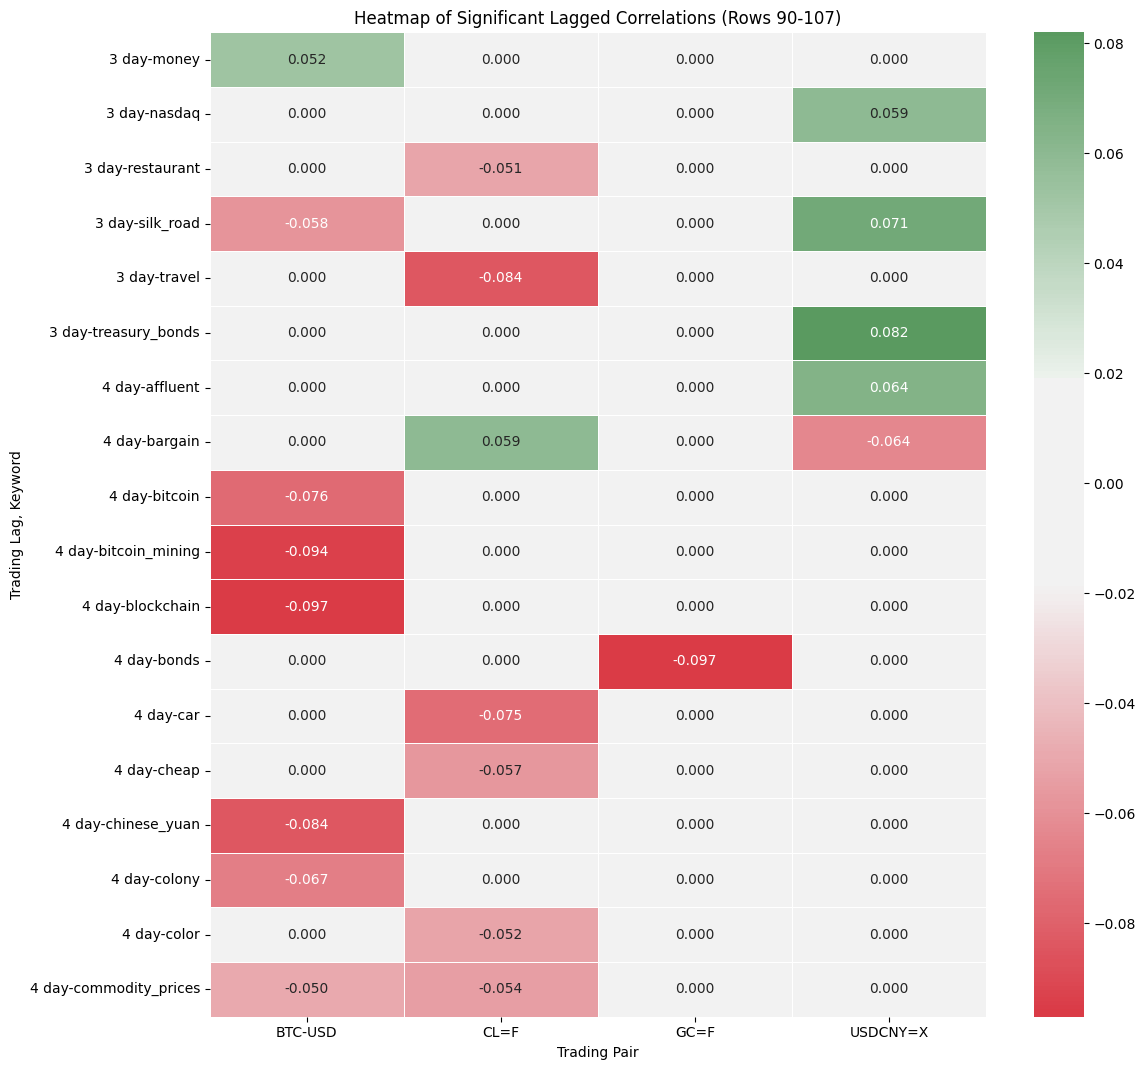

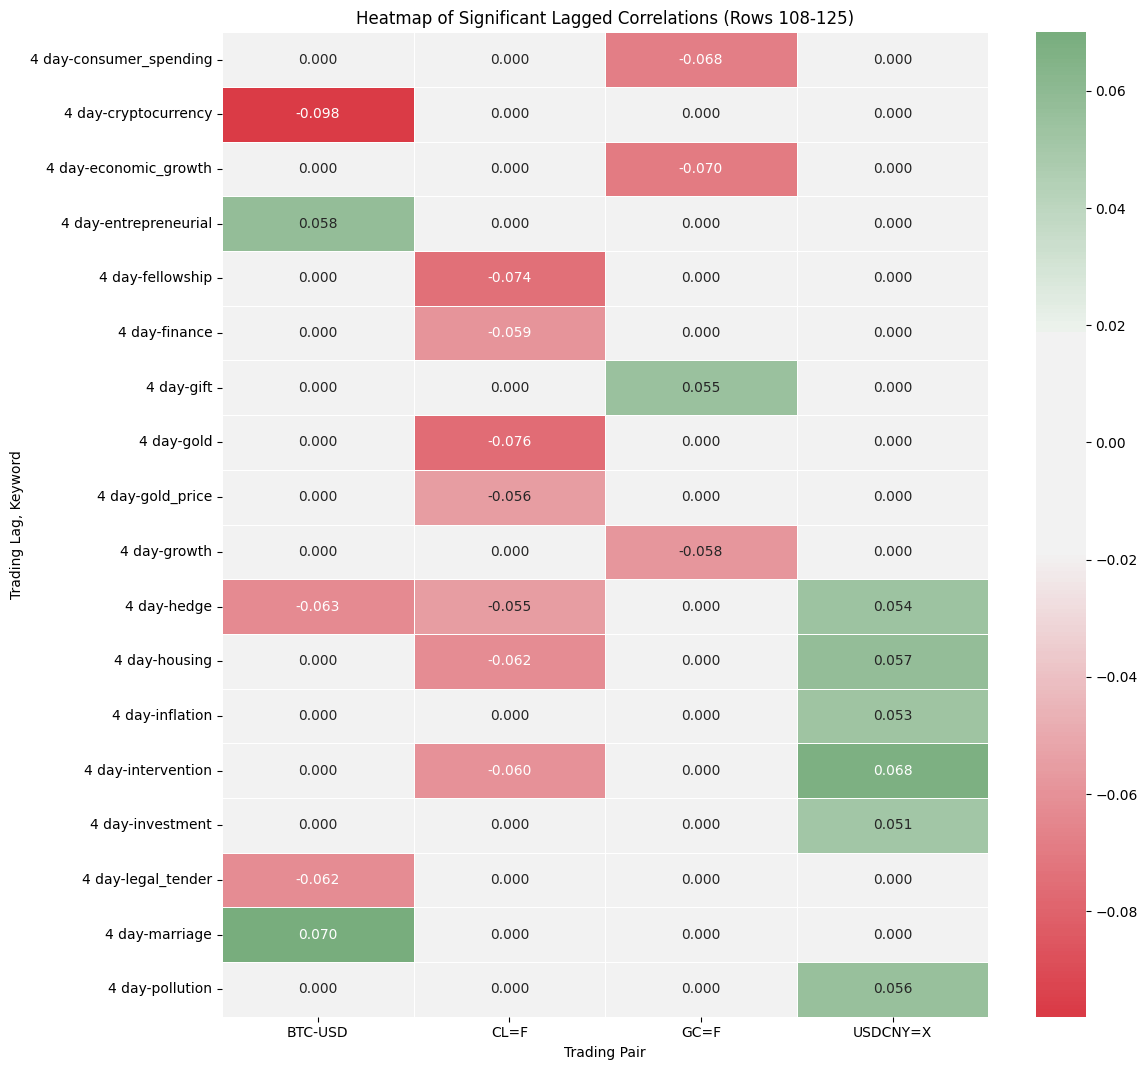

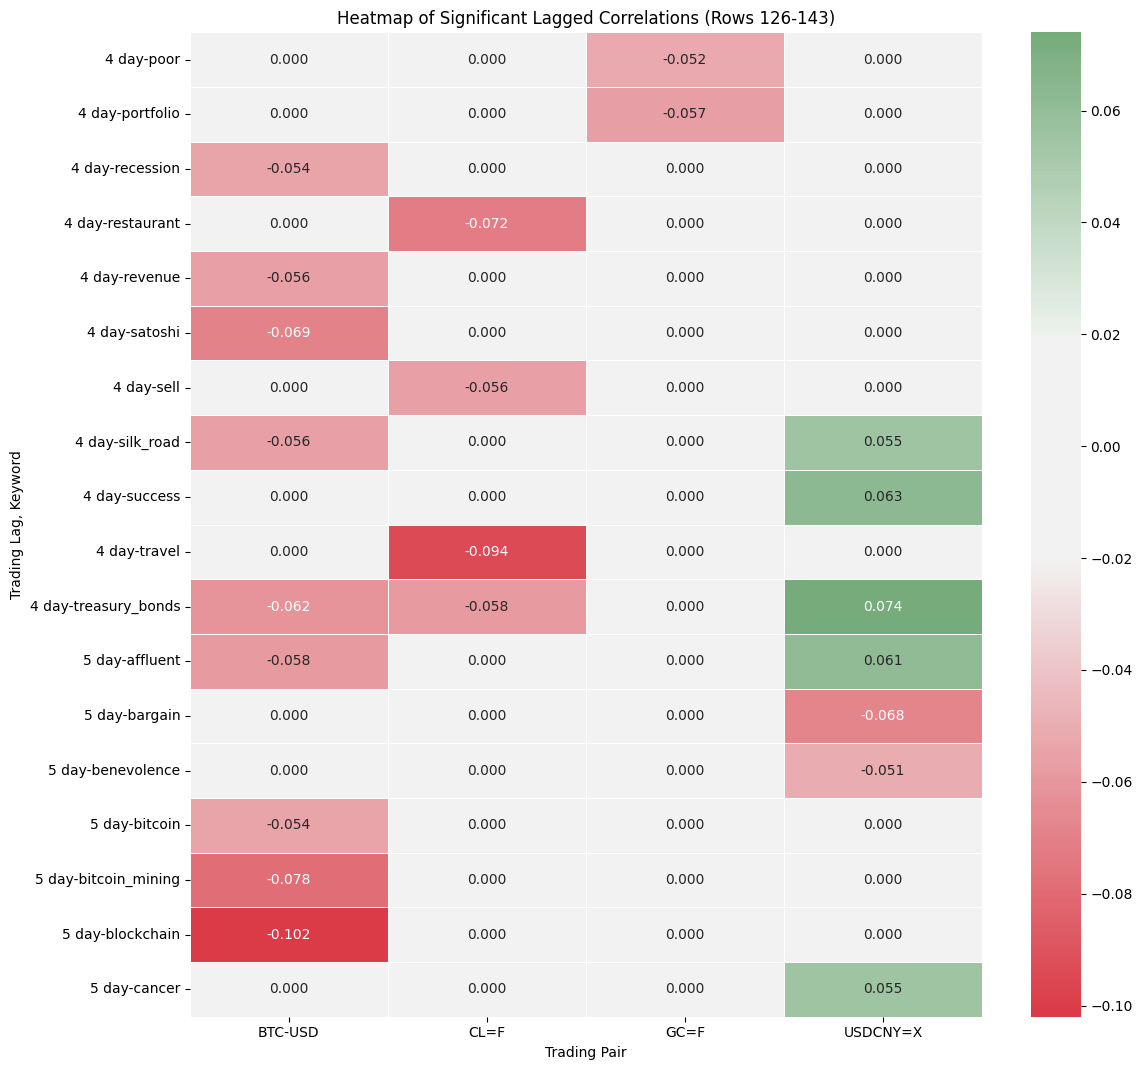

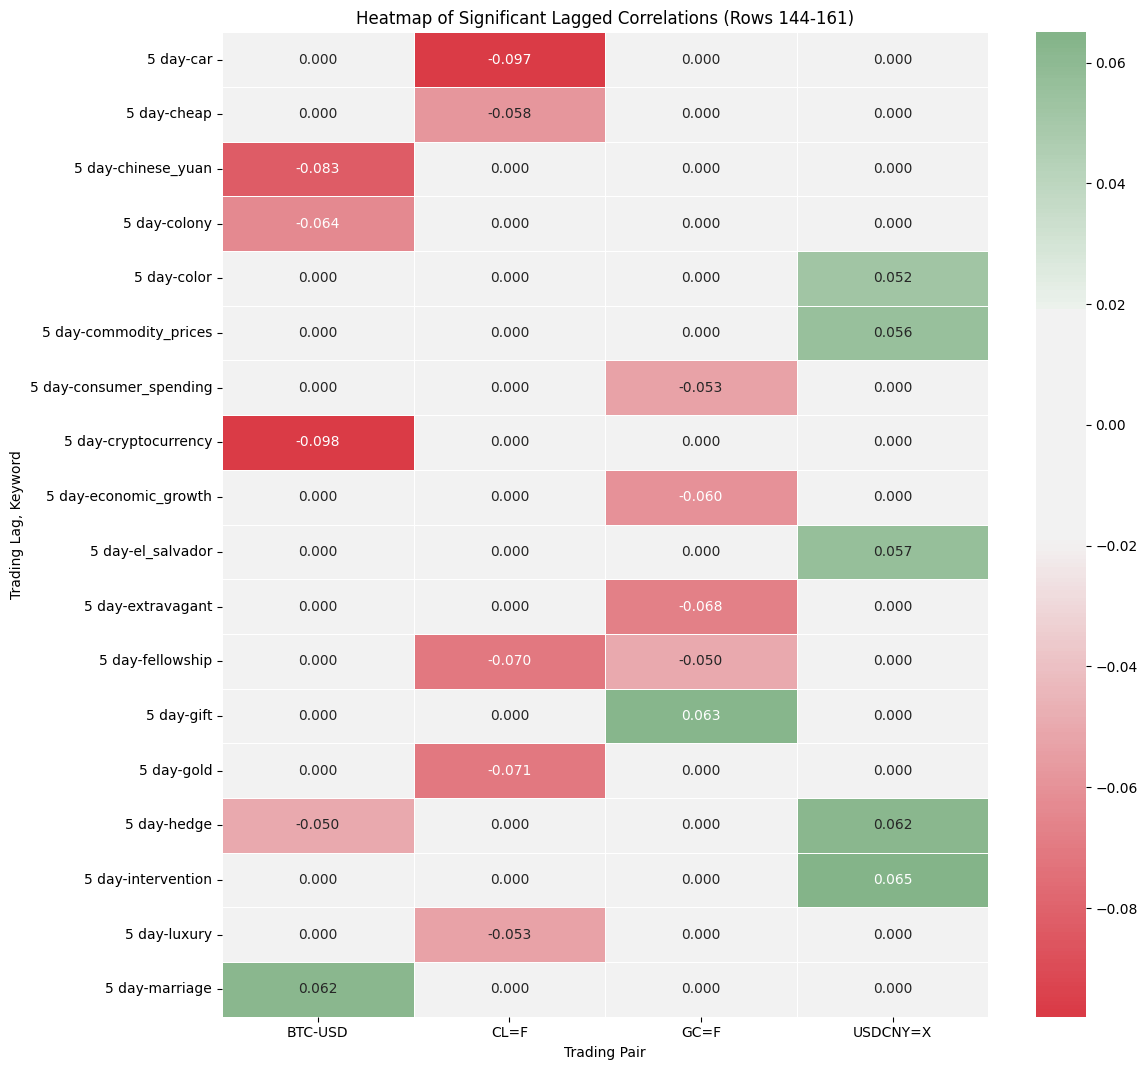

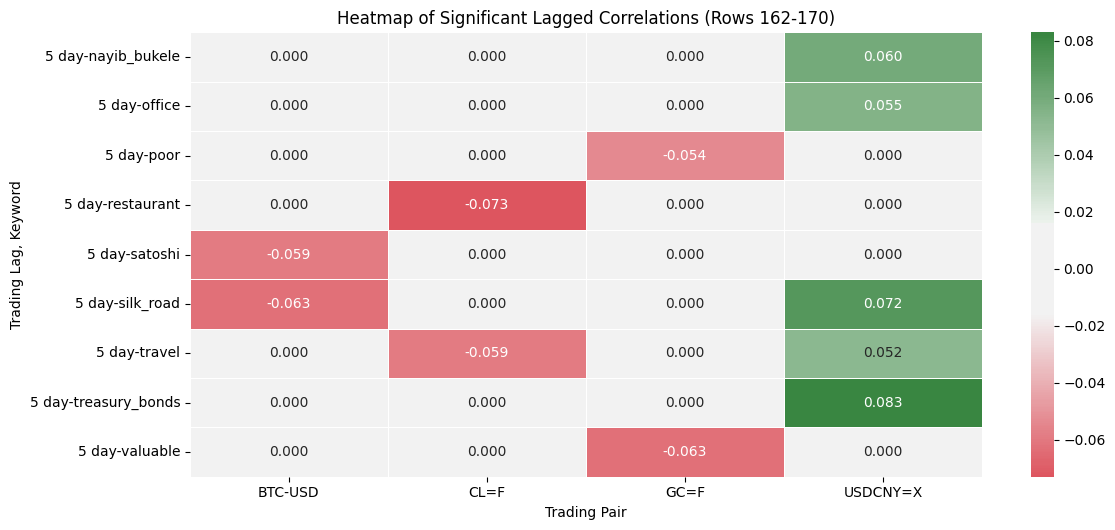

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Import pandas to use iloc
import numpy as np # Import numpy for handling potential NaN values

# Ensure pivot_df is available and not empty
if 'pivot_df' in locals() and not pivot_df.empty:
    print("Displaying pivot_df as a heatmap in 10 equal parts.")

    num_rows = pivot_df.shape[0]
    # Calculate chunk size to divide into 10 equal parts
    # Use ceil to ensure all rows are included, even if not perfectly divisible by 10
    chunk_size = max(1, int(np.ceil(num_rows / 10)))


    # Define the custom colormap: Red for negative, Yellow for zero, Green for positive
    # Using a built-in diverging colormap like 'RdYlGn' and setting the center to 0
    cmap = sns.diverging_palette(10, 130, sep=50, as_cmap=True) # Adjust h_neg, h_pos, and sep for desired shades

    for i in range(0, num_rows, chunk_size):
        # Get the current chunk of data
        chunk_df = pivot_df.iloc[i:i + chunk_size]

        if not chunk_df.empty:
            # Adjusted figure size calculation to provide more vertical space per row
            plt.figure(figsize=(12, max(5, chunk_df.shape[0] * 0.6))) # Adjusted factor from 0.8 to 0.6, and set a minimum size

            # Create the heatmap with the custom colormap and center at 0
            sns.heatmap(chunk_df, annot=True, cmap=cmap, fmt=".3f", linewidths=.5, center=0)

            # Determine the title for the chunk
            start_index = i
            end_index = min(i + chunk_size, num_rows)
            plt.title(f'Heatmap of Significant Lagged Correlations (Rows {start_index}-{end_index-1})')

            plt.xlabel('Trading Pair')
            plt.ylabel('Trading Lag, Keyword')
            plt.tight_layout() # Adjust layout to prevent labels overlapping
            plt.show()
        else:
            print(f"Chunk starting at index {i} is empty.")


else:
    print("The DataFrame 'pivot_df' is empty or not found. Please run the previous cell to create it.")

In [83]:
import pandas as pd

# Ensure combined_significant_correlations_df is available and not empty
if 'combined_significant_correlations_df' in locals() and not combined_significant_correlations_df.empty:
    print("Filtering keywords that impact 3 or more trading pairs.")

    # Group by 'Keyword' and count the number of unique trading pairs
    keyword_pair_counts = combined_significant_correlations_df.groupby('Keyword')['Pair'].nunique()

    # Identify keywords that appear in 3 or more unique trading pairs
    keywords_impacting_3_plus_pairs = keyword_pair_counts[keyword_pair_counts >= 3].index.tolist()

    # Filter the original combined DataFrame to include only these keywords
    keywords_impacting_3_plus_pairs_df = combined_significant_correlations_df[
        combined_significant_correlations_df['Keyword'].isin(keywords_impacting_3_plus_pairs)
    ].copy() # Use .copy() to avoid SettingWithCopyWarning

    if not keywords_impacting_3_plus_pairs_df.empty:
        # Reorder columns to have 'Keyword' first
        ordered_columns = ['Keyword', 'Pair', 'Correlation', 'trading lag']
        keywords_impacting_3_plus_pairs_df = keywords_impacting_3_plus_pairs_df[ordered_columns]

        # Sort by 'Keyword'
        keywords_impacting_3_plus_pairs_df = keywords_impacting_3_plus_pairs_df.sort_values(by='Keyword')


        print("\nKeywords impacting 3 or more trading pairs and their significant lagged correlations (sorted by Keyword):")
        display(keywords_impacting_3_plus_pairs_df)
    else:
        print("\nNo keywords found that impact 3 or more trading pairs with significant lagged correlations (|r| > 0.05).")

else:
    print("The DataFrame 'combined_significant_correlations_df' is empty or not found. Please run the cell that creates it.")

Filtering keywords that impact 3 or more trading pairs.

Keywords impacting 3 or more trading pairs and their significant lagged correlations (sorted by Keyword):


,Keyword,Pair,Correlation,trading lag
104,bargain,BTC-USD,0.052,1 day
172,bargain,CL=F,0.059,4 day
171,bargain,CL=F,0.070,3 day
57,bargain,USDCNY=X,-0.068,5 day
170,bargain,CL=F,0.051,2 day
169,bargain,CL=F,0.051,1 day
56,bargain,USDCNY=X,-0.064,4 day
55,bargain,USDCNY=X,-0.070,3 day
105,bargain,BTC-USD,0.052,3 day
95,commodity_prices,BTC-USD,-0.056,2 day


In [84]:
import pandas as pd
import numpy as np

# Ensure df_btc_cleaned is available and not empty
if 'df_btc_cleaned' in locals() and not df_btc_cleaned.empty:
    print("Preparing data for Logistic Regression on BTC-USD.")

    # --- 1. Prepare the Data ---
    # Create the target variable: 1 if BTC log return > 0, 0 otherwise
    target = (df_btc_cleaned['BTC-USD Log Returns'] > 0).astype(int)
    print(f"\nTarget variable created. Number of 'price up' days (1): {target.sum()}, 'price down/no change' days (0): {len(target) - target.sum()}")

    # Select features: Google Trends features and Technical indicators
    # Exclude log returns and other related columns that would cause look-ahead bias
    trend_columns = [col for col in df_btc_cleaned.columns if col.endswith('_trend')]
    # Identify technical indicator columns (adjust this based on your specific column names)
    # Assuming technical indicator columns contain 'day' or specific indicator names
    tech_indicator_columns = [col for col in df_btc_cleaned.columns if any(indicator in col for indicator in ['day', 'simple moving average', 'RSI', 'Rolling Volatility']) and 'BTC-USD' in col and 'Log Returns' not in col]

    feature_columns = trend_columns + tech_indicator_columns

    # Ensure all selected feature columns exist in the DataFrame
    available_features = [col for col in feature_columns if col in df_btc_cleaned.columns]
    missing_features = [col for col in feature_columns if col not in df_btc_cleaned.columns]

    if missing_features:
        print(f"\nWarning: The following feature columns were not found in df_btc_cleaned and will be excluded: {missing_features}")

    features = df_btc_cleaned[available_features]

    print(f"\nSelected {len(available_features)} features for the model.")
    print("Feature columns:", available_features)

    # Display the head of features and target to confirm
    print("\nFeatures (first 5 rows):")
    display(features.head())
    print("\nTarget (first 5 rows):")
    display(target.head())

    # Check for any remaining null values in features
    if features.isnull().sum().sum() > 0:
        print("\nWarning: There are still null values in the selected features. Consider handling them before training.")
        # For now, we'll let scikit-learn handle them or rely on a model that can handle NaNs.
        # A common approach is to fill NaNs with the mean, median, or a constant.
        # Example: features = features.fillna(features.mean())


else:
    print("The DataFrame 'df_btc_cleaned' is empty or not found. Please run the cell that creates and cleans it first.")
    target = pd.Series() # Initialize as empty if df_btc_cleaned is not available
    features = pd.DataFrame() # Initialize as empty if df_btc_cleaned is not available

Preparing data for Logistic Regression on BTC-USD.

Target variable created. Number of 'price up' days (1): 804, 'price down/no change' days (0): 632

Selected 86 features for the model.
Feature columns: ['usd_trend', 'gold_price_trend', 'bitcoin_trend', 'oil_price_trend', 'chinese_yuan_trend', 'inflation_trend', 'interest_rates_trend', 'stock_market_trend', 'recession_trend', 'economic_growth_trend', 'currency_exchange_trend', 'commodity_prices_trend', 'treasury_bonds_trend', 'central_bank_trend', 'consumer_spending_trend', 'intervention_trend', 'gamble_trend', 'gold_trend', 'luxury_trend', 'ruin_trend', 'associate_trend', 'cooperative_trend', 'pollution_trend', 'success_trend', 'gift_trend', 'affluent_trend', 'benevolence_trend', 'partnership_trend', 'poor_trend', 'blackmail_trend', 'privileged_trend', 'ghetto_trend', 'extravagant_trend', 'nobility_trend', 'cheap_trend', 'entrepreneurial_trend', 'jobless_trend', 'shortage_trend', 'fellowship_trend', 'inexpensive_trend', 'valuable_tre

,usd_trend,gold_price_trend,bitcoin_trend,oil_price_trend,chinese_yuan_trend,inflation_trend,interest_rates_trend,stock_market_trend,recession_trend,economic_growth_trend,...,bitcoin_mining_trend,blockchain_trend,silk_road_trend,tor_trend,nigeria_trend,legal_tender_trend,nayib_bukele_trend,BTC-USD 20-day simple moving average,BTC-USD 14-day RSI,BTC-USD 30-day Rolling Volatility
Date,,,,,,,,,,,,,,,,,,,,,
2016-03-08,30,32,32,100,59,93,54,15,34,90,...,43,55,76,66,46,36,0,415.527296,48.692785,0.022077
2016-03-09,28,34,32,83,52,94,51,16,35,96,...,43,62,67,61,45,64,31,417.187846,45.566137,0.022056
2016-03-10,31,31,32,80,58,100,60,15,34,94,...,35,66,78,64,44,49,32,419.061697,47.860811,0.020790
2016-03-11,28,27,34,76,51,86,51,15,29,73,...,38,57,69,60,44,37,33,420.933047,39.001685,0.020810
2016-03-14,29,32,33,74,47,95,54,15,34,89,...,35,63,75,63,45,50,0,421.745697,46.490969,0.020672



Target (first 5 rows):


,BTC-USD Log Returns
Date,
2016-03-08,0
2016-03-09,1
2016-03-10,1
2016-03-11,1
2016-03-14,0


In [85]:
from sklearn.model_selection import train_test_split

# Ensure features and target are available and not empty
if 'features' in locals() and not features.empty and 'target' in locals() and not target.empty:
    print("Splitting data into training and testing sets.")

    # --- 2. Train/Test Split ---
    # Split the data chronologically (no shuffling)
    # Use the index to split while preserving order
    train_size = 0.8
    split_index = int(len(features) * train_size)

    X_train, X_test = features.iloc[:split_index], features.iloc[split_index:]
    y_train, y_test = target.iloc[:split_index], target.iloc[split_index:]

    print(f"\nData split chronologically:")
    print(f"Training set shape: Features {X_train.shape}, Target {y_train.shape}")
    print(f"Testing set shape: Features {X_test.shape}, Target {y_test.shape}")

    # Display the first and last index of train and test sets to confirm chronological split
    print(f"\nTraining set index range: {X_train.index.min()} to {X_train.index.max()}")
    print(f"Testing set index range: {X_test.index.min()} to {X_test.index.max()}")

else:
    print("Features or target DataFrame is empty or not found. Please run the previous cell to prepare the data.")
    X_train, X_test, y_train, y_test = pd.DataFrame(), pd.DataFrame(), pd.Series(), pd.Series() # Initialize as empty if data is not available

Splitting data into training and testing sets.

Data split chronologically:
Training set shape: Features (1148, 86), Target (1148,)
Testing set shape: Features (288, 86), Target (288,)

Training set index range: 2016-03-08 00:00:00 to 2020-07-30 00:00:00
Testing set index range: 2020-07-31 00:00:00 to 2021-09-07 00:00:00


In [88]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import numpy as np

# Ensure training data is available and not empty
if 'X_train' in locals() and not X_train.empty and 'y_train' in locals() and not y_train.empty:
    print("Training the Logistic Regression model with preprocessing pipeline.")

    # --- 3. Train Model ---
    # Create a preprocessing pipeline for handling NaNs and scaling features
    # Use SimpleImputer to fill missing values (e.g., with the mean)
    # Use StandardScaler to scale features (important for logistic regression)
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')), # Strategy can be 'median', 'most_frequent', or 'constant'
        ('scaler', StandardScaler()),
        ('logistic_regression', LogisticRegression(max_iter=1000)) # Use max_iter=1000 as requested
    ])

    try:
        # Fit the pipeline on the training data
        pipeline.fit(X_train, y_train)
        print("\nLogistic Regression model trained successfully with preprocessing pipeline.")
        # The trained model is now accessible as pipeline['logistic_regression']
        # The imputer is pipeline['imputer'] and the scaler is pipeline['scaler']

    except Exception as e:
        print(f"\nError during model training: {e}")
        pipeline = None # Set pipeline to None if training fails
        model = None # Also set model to None for clarity

else:
    print("Training data (X_train or y_train) is empty or not found. Please run the previous cell to split the data.")
    pipeline = None # Initialize pipeline as None if training data is not available
    model = None # Initialize model as None for clarity

Training the Logistic Regression model with preprocessing pipeline.

Logistic Regression model trained successfully with preprocessing pipeline.


In [89]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score

# Ensure the trained pipeline and test data are available
if 'pipeline' in locals() and pipeline is not None and 'X_test' in locals() and not X_test.empty and 'y_test' in locals() and not y_test.empty:
    print("Evaluating the Logistic Regression model on the test set.")

    # --- 4. Evaluate Model ---
    # Make predictions on the test set using the trained pipeline
    # The pipeline will automatically apply imputation and scaling learned from the training data
    try:
        y_pred = pipeline.predict(X_test)
        y_proba = pipeline.predict_proba(X_test)[:, 1] # Get probability of the positive class (class 1)

        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_proba)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)

        print(f"\nModel Evaluation Metrics on the Test Set:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"ROC-AUC: {roc_auc:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")

    except Exception as e:
        print(f"\nError during model evaluation: {e}")

else:
    print("Trained pipeline or test data (X_test or y_test) is not available. Please run the previous cells.")

Evaluating the Logistic Regression model on the test set.

Model Evaluation Metrics on the Test Set:
Accuracy: 0.5903
ROC-AUC: 0.6055
Precision: 0.7034
Recall: 0.5000


In [90]:
import pandas as pd

# Ensure the trained pipeline is available and contains the logistic regression model
if 'pipeline' in locals() and pipeline is not None and 'logistic_regression' in pipeline.named_steps:
    print("Interpreting the model coefficients.")

    # --- 5. Interpret Coefficients ---
    # Get the logistic regression model from the pipeline
    model = pipeline.named_steps['logistic_regression']

    # Get the feature names after preprocessing (imputation and scaling)
    # The scaler in the pipeline will have the correct order of features
    # Note: If columns were dropped by the imputer, this will need adjustment.
    # Assuming SimpleImputer with 'mean' doesn't drop columns unless all NaNs,
    # and we handled that previously or the scaler handles it.
    # A more robust way is to get feature names from the fitted scaler.
    # However, StandardScaler doesn't have get_feature_names_out in older versions.
    # Let's use the feature names from X_train after imputation and scaling are applied *conceptually* by the pipeline.
    # A simpler way is to rely on the order of features in X_train before pipeline fit,
    # assuming the pipeline preserves column order for features not dropped by the imputer.

    # Get feature names from the original X_train columns that were not dropped
    # We need to use the feature names that actually went into the scaler and model
    # The SimpleImputer might remove columns if strategy='constant' and fill_value=None,
    # or if strategy='mean/median' and a column is all NaNs (which we handled in training cell, but need consistency here).
    # Let's assume the columns in X_train that went into the successful pipeline fit are the ones we need.
    # A safe way is to get the feature names from the imputer's fitted features if it supports it,
    # or map back using the columns that were *not* dropped in preprocessing steps if any.

    # Let's try getting feature names from the imputer if possible, or fall back to original X_train columns
    try:
        # This might work depending on the SimpleImputer version and how it handles feature names
        feature_names = pipeline.named_steps['imputer'].get_feature_names_out()
        print("Obtained feature names from imputer.")
    except (AttributeError, TypeError):
        print("Could not get feature names from imputer. Using original X_train columns.")
        # Fallback to original X_train columns, assuming order is preserved for columns that weren't all NaN in training
        # We need to ensure these match the features the model was actually trained on.
        # A more robust approach would involve inspecting the fitted imputer and scaler outputs.
        # For this scenario, let's use the columns from X_train directly, as the imputer and scaler
        # in the pipeline should handle their transformation internally.
        # We should ensure X_train used here is consistent with what went into the pipeline fit.
        # The columns of X_train after potential dropping in the training cell are the relevant ones.
        # Let's use the columns of X_train directly here, assuming they align with model.coef_[0]
        # This might break if the imputer significantly changes the number/order of columns in a way not reflected here.
        feature_names = X_train.columns.tolist()
        # Need to be careful if columns were dropped due to all NaNs in the training cell.
        # Let's use the columns of the processed X_train from the previous cell if it exists.
        if 'X_train_processed' in locals() and not X_train_processed.empty:
             print("Using processed X_train columns for interpretation.")
             feature_names = X_train_processed.columns.tolist()
        elif 'features' in locals() and not features.empty:
             print("Using original features columns for interpretation (warning: may not match exactly if columns were dropped).")
             feature_names = features.columns.tolist()
        else:
             print("Warning: Cannot determine feature names accurately for interpretation.")
             feature_names = [f'Feature {i}' for i in range(model.coef_.shape[1])] # Generate dummy names


    # Get the coefficients and the intercept
    coefficients = model.coef_[0] # Assuming binary classification, get the coefficients for class 1
    intercept = model.intercept_[0]

    # Create a DataFrame for better readability
    coefficients_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    })

    # Sort coefficients by their absolute value to see the most impactful features
    coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False)

    print("\nModel Coefficients:")
    display(coefficients_df)
    print(f"\nIntercept: {intercept:.4f}")

    print("\nInterpretation:")
    print("- A positive coefficient for a feature suggests that an increase in that feature's value (holding others constant) increases the log-odds of the BTC price going up.")
    print("- A negative coefficient suggests that an increase in that feature's value (holding others constant) decreases the log-odds of the BTC price going up (i.e., increases the log-odds of it going down).")
    print("- The magnitude of the coefficient indicates the strength of the relationship.")


else:
    print("Trained pipeline or Logistic Regression model not available. Please run the previous cells to train the model.")

Interpreting the model coefficients.
Obtained feature names from imputer.

Model Coefficients:


,Feature,Coefficient
84,BTC-USD 14-day RSI,0.642591
0,usd_trend,0.495656
49,dow_jones_trend,0.464578
47,portfolio_trend,0.422648
77,blockchain_trend,0.344640
...,...,...
67,sell_trend,-0.257126
10,currency_exchange_trend,-0.307619
53,money_trend,-0.310934
57,investment_trend,-0.583020



Intercept: 0.2615

Interpretation:
- A positive coefficient for a feature suggests that an increase in that feature's value (holding others constant) increases the log-odds of the BTC price going up.
- A negative coefficient suggests that an increase in that feature's value (holding others constant) decreases the log-odds of the BTC price going up (i.e., increases the log-odds of it going down).
- The magnitude of the coefficient indicates the strength of the relationship.
